## Connectivity Magnitude Analysis
#### This script is designed to quantify similarities and differences between two aspects of the visual pathways in object perception.

In [ ]:
# Cell 0: previously deleted cell extracting merged atlas data
## Merged atlas created here: being_verified/exp_1/network/merged_atlas.ipynb
# Regional Brain Connectivity Analysis Part 1: Analysis and CSV Export
# Description: Analysis of functional connectivity (FC) and psychophysiological interaction (PPI)
#              between parietal IPS and lateral occipital regions with CSV export

import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from sklearn.utils import resample

# Define study paths
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_comparison'
os.makedirs(output_dir, exist_ok=True)

def analyze_connectivity_and_save_results(analysis_type='fc'):
    """Analyze connectivity and save results as CSV using merged atlas"""
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} CONNECTIVITY AND SAVING RESULTS")
    print(f"{'='*80}")
    
    # Load merged atlas instead of fetching standard Schaefer atlas
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    merged_labels_file = f'{results_dir}/merged_atlas_labels.npy'
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Error: Merged atlas files not found. Please run merge_atlas.py first.")
        return None
    
    atlas_img = nib.load(merged_atlas_file)
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    
    print(f"Loaded merged atlas with {len(atlas_labels)} parcels")
    
    # Load subject info
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    
    # Exclude sub-084 as specified
    if 'sub-084' in subjects:
        subjects.remove('sub-084')
        print("Excluded sub-084 from analysis")
        
    print(f"Found {len(subjects)} control subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Setup atlas masker
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
    
    # Load and process subject data
    subject_data = []
    for sub in subjects:
        sub_conn = {}
        
        for roi in rois:
            # Initialize arrays to hold combined data
            combined_data = None
            hemi_count = 0
            
            for hemisphere in hemispheres:
                fc_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemisphere}_loc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(fc_file):
                    try:
                        # Load the FC map
                        fc_img = nib.load(fc_file)
                        
                        # Extract ROI values using atlas
                        fc_values = masker.fit_transform(fc_img)[0]
                        
                        # Add to combined data
                        if combined_data is None:
                            combined_data = fc_values
                        else:
                            combined_data += fc_values
                        
                        hemi_count += 1
                    except Exception as e:
                        print(f"Error processing {fc_file}: {e}")
            
            # Average the data if we have at least one hemisphere
            if hemi_count > 0:
                sub_conn[roi] = combined_data / hemi_count
        
        # Only include subjects with both ROIs
        if len(sub_conn) == len(rois):
            subject_data.append(sub_conn)
    
    n_valid_subjects = len(subject_data)
    print(f"Successfully loaded data for {n_valid_subjects} subjects")
    
    if n_valid_subjects < 3:
        print("Not enough valid subjects. Analysis cannot proceed.")
        return None
    
    # Initialize arrays for analysis
    n_rois = len(atlas_labels)
    pips_fc = np.zeros((n_valid_subjects, n_rois))
    lo_fc = np.zeros((n_valid_subjects, n_rois))
    
    # Fill arrays with connectivity data
    for i, subj_data in enumerate(subject_data):
        pips_fc[i, :] = subj_data['pIPS']
        lo_fc[i, :] = subj_data['LO']
    
    # Calculate connectivity vector correlation for each subject
    vector_correlations = np.zeros(n_valid_subjects)
    for i in range(n_valid_subjects):
        vector_correlations[i] = np.corrcoef(pips_fc[i, :], lo_fc[i, :])[0, 1]
    
    print(f"Mean connectivity vector correlation: {np.mean(vector_correlations):.3f} ± {np.std(vector_correlations):.3f}")
    
    # Calculate mean connectivity profiles
    mean_pips = np.mean(pips_fc, axis=0)
    mean_lo = np.mean(lo_fc, axis=0)
    
    # Remove self-connectivity
    # Get indices for Wang ROIs in the merged atlas
    wang_pips_idx = next((i for i, label in enumerate(atlas_labels) if 'Wang_pIPS' in str(label)), None)
    wang_lo_idx = next((i for i, label in enumerate(atlas_labels) if 'Wang_LO' in str(label)), None)
    
    # Print which indices are being excluded
    if wang_pips_idx is not None:
        print(f"Excluding Wang_pIPS (index {wang_pips_idx}) from connectivity analysis")
    if wang_lo_idx is not None:
        print(f"Excluding Wang_LO (index {wang_lo_idx}) from connectivity analysis")
    
    # Create mask for non-self connections (all True except at Wang ROI indices)
    mask = np.ones(len(atlas_labels), dtype=bool)
    if wang_pips_idx is not None:
        mask[wang_pips_idx] = False
    if wang_lo_idx is not None:
        mask[wang_lo_idx] = False
    
    # Apply mask to connectivity data
    pips_fc_masked = pips_fc[:, mask]
    lo_fc_masked = lo_fc[:, mask]
    
    # Get the masked atlas labels
    atlas_labels_masked = [label for i, label in enumerate(atlas_labels) if mask[i]]
    
    # Update mean connectivity with masked data
    mean_pips_masked = np.mean(pips_fc_masked, axis=0)
    mean_lo_masked = np.mean(lo_fc_masked, axis=0)
    
    # Get the new number of ROIs after masking
    n_masked_rois = np.sum(mask)
    print(f"Analyzing {n_masked_rois} ROIs after excluding Wang ROIs")
    
    # Calculate difference profile with masked data
    diff_profile = mean_pips_masked - mean_lo_masked
    abs_diff_profile = np.abs(diff_profile)
    
    # Run bootstrap analysis with masked data
    print("Performing bootstrap analysis...")
    n_boots = 10000
    boot_diffs = np.zeros((n_boots, n_masked_rois))
    
    for i in range(n_boots):
        # Resample subjects with replacement
        boot_idx = resample(range(n_valid_subjects), replace=True, n_samples=n_valid_subjects)
        
        # Calculate mean difference for this bootstrap sample
        boot_pips = np.mean(pips_fc_masked[boot_idx, :], axis=0)
        boot_lo = np.mean(lo_fc_masked[boot_idx, :], axis=0)
        boot_diffs[i, :] = boot_pips - boot_lo
    
    # Calculate confidence intervals
    ci_lower = np.percentile(boot_diffs, 2.5, axis=0)
    ci_upper = np.percentile(boot_diffs, 97.5, axis=0)
    
    # Identify significant differences (95% CI doesn't cross zero)
    sig_boot = (ci_lower > 0) | (ci_upper < 0)
    sig_boot_count = np.sum(sig_boot)
    print(f"Found {sig_boot_count} ROIs with significant differences via bootstrap")
    
    # Leave-One-Out Cross-Validation for reliability
    print("Performing Leave-One-Out Cross-Validation...")
    loo_reliability = np.zeros(n_masked_rois)
    
    for left_out in range(n_valid_subjects):
        # Create the training set (all subjects except the left out one)
        train_idx = list(range(n_valid_subjects))
        train_idx.remove(left_out)
        
        # Calculate mean training differences
        train_diff = np.mean(pips_fc_masked[train_idx, :] - lo_fc_masked[train_idx, :], axis=0)
        
        # Test on left out subject
        test_diff = pips_fc_masked[left_out, :] - lo_fc_masked[left_out, :]
        
        # Calculate consistency of signs between training and test
        loo_reliability += (np.sign(train_diff) == np.sign(test_diff)).astype(float)
    
    # Convert to proportion of consistent predictions
    loo_reliability = loo_reliability / n_valid_subjects
    
    # Set threshold at 75% consistency
    loo_threshold = 0.75
    sig_loo = loo_reliability >= loo_threshold
    sig_loo_count = np.sum(sig_loo)
    
    print(f"LOO reliability threshold: {loo_threshold:.3f}")
    print(f"Found {sig_loo_count} ROIs with high reliability via LOO")
    
    # Combine significance
    sig_combined = sig_boot & sig_loo
    sig_combined_count = np.sum(sig_combined)
    print(f"Found {sig_combined_count} ROIs significant with combined criteria")
    
    # Helper function to get ROI name
    def get_roi_name(roi_id):
        try:
            idx = int(roi_id) - 1
            if 0 <= idx < len(atlas_labels):
                label = atlas_labels[idx]
                if isinstance(label, bytes):
                    label = label.decode('utf-8')
                return label
        except:
            pass
        return f"ROI_{roi_id}"
    
    # Create a map from masked indices to original atlas indices
    original_indices = np.where(mask)[0]
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'ROI_ID': original_indices + 1,  # Convert to 1-based indexing
        'ROI_Name': [get_roi_name(i+1) for i in original_indices],
        'pIPS_Connectivity': mean_pips_masked,
        'LO_Connectivity': mean_lo_masked,
        'Difference': diff_profile,
        'Abs_Difference': abs_diff_profile,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper,
        'LOO_Reliability': loo_reliability,
        'Bootstrap_Significant': sig_boot,
        'LOO_Significant': sig_loo,
        'Combined_Significant': sig_combined,
        'Direction': np.where(diff_profile > 0, 'pIPS > LO', 'LO > pIPS')
    })
    
    # Save results to CSV
    csv_path = f'{output_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")
    
    # Create roi_data dictionary for visualization
    roi_data = {
        'mean_pips': mean_pips_masked,
        'mean_lo': mean_lo_masked,
        'diff_profile': diff_profile,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'sig_combined': sig_combined
    }
    
    return results_df, roi_data

# Run analyses for both FC and PPI
print("\nRunning FC and PPI analyses and saving results...")
print("\n----- FC ANALYSIS -----")
fc_results, fc_data = analyze_connectivity_and_save_results(analysis_type='fc')
print("\n----- PPI ANALYSIS -----")
ppi_results, ppi_data = analyze_connectivity_and_save_results(analysis_type='ppi')

print("\nAnalyses complete - results were saved to disk.")

In [28]:
# Cell 1: Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch
from scipy.stats import ttest_rel 

In [29]:
# Cell 2: Load FC and PPI data
# Define paths - modify these to match your environment
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_comparison'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# File paths for FC and PPI data
fc_csv_path = f'{output_dir}/bilateral_fc_connectivity_fingerprint_results.csv'
ppi_csv_path = f'{output_dir}/bilateral_ppi_connectivity_fingerprint_results.csv'

# Path to merged atlas labels
merged_labels_file = f'{results_dir}/merged_atlas_labels.npy'

In [30]:
# Cell 3: Define Helper Functions for ROI Classification
def map_to_anatomical_lobe(roi_name):
    """Map ROI names to anatomical lobes"""
    # Convert bytes to string if needed
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    # Special handling for Wang atlas ROIs
    if 'Wang_pIPS' in roi_name:
        return 'Parietal'
    elif 'Wang_LO' in roi_name:
        return 'Temporal'
    
    # Map Schaefer networks to anatomical regions
    if 'Vis' in roi_name:
        return 'Occipital'
    elif 'SomMot' in roi_name:
        return 'Somatomotor'
    elif 'DorsAttn' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        else:
            return 'Parietal'
    elif 'SalVentAttn' in roi_name:
        if 'Ins' in roi_name:
            return 'Insular'
        elif 'Cing' in roi_name or 'ACC' in roi_name:
            return 'Cingulate'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'Par' in roi_name:
            return 'Parietal'
        else:
            return 'Frontal'
    elif 'Limbic' in roi_name:
        if 'Temp' in roi_name:
            return 'Temporal'
        else:
            return 'Frontal'
    elif 'Cont' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        elif 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    elif 'Default' in roi_name:
        if 'Par' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'PCC' in roi_name or 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    else:
        return 'Other'

def clean_roi_name(roi_name):
    """Clean up ROI names for better labeling"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    # Handle Wang ROIs
    if 'Wang_' in roi_name:
        return roi_name.replace('Wang_', '')
    
    # Remove common prefixes and suffixes
    cleaned = roi_name.replace('7Networks_', '')
    
    # Extract just the region part, removing hemisphere and network
    parts = cleaned.split('_')
    if len(parts) > 2:
        return parts[-2] + '_' + parts[-1]
    elif len(parts) > 1:
        return parts[-1]
    else:
        return cleaned

def get_hemisphere_and_region(roi_name):
    """Determine hemisphere and base region for organizing pairs"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    # Determine hemisphere 
    if 'LH' in roi_name:
        hemisphere = 'L'
    elif 'RH' in roi_name:
        hemisphere = 'R'
    else:
        # For Wang ROIs or ROIs without clear hemisphere
        if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
            hemisphere = 'X'  # Bilateral
        else:
            hemisphere = 'X'  # Unknown
    
    # Extract base region by removing hemisphere and number
    cleaned = roi_name.replace('7Networks_', '')
    cleaned = cleaned.replace('LH_', '').replace('RH_', '')
    
    # Handle Wang ROIs
    if 'Wang_' in cleaned:
        base_region = cleaned.replace('Wang_', '')
    else:
        # Remove trailing numbers which often differentiate regions
        base_region = re.sub(r'_\d+$', '', cleaned)
    
    return hemisphere, base_region

In [33]:
# Cell 4: Main Visualization Function
def visualize_anatomical_organization(results_df, roi_data, analysis_type='fc'):
    """Create anatomical organization visualization with:
    - Lobes ordered posterior to anterior
    - Lobe labels at the bottom of both panels
    - No x-axis numbers
    - Only label positive max (pIPS-preferring) and negative min (LO-preferring) ROIs
    """
    print(f"\nCreating {analysis_type.upper()} anatomical organization visualization...")
    
    # Extract data from parameters
    mean_pips = roi_data['mean_pips']
    mean_lo = roi_data['mean_lo']
    diff_profile = roi_data['diff_profile']
    ci_lower = roi_data['ci_lower']
    ci_upper = roi_data['ci_upper']
    sig_combined = roi_data['sig_combined']
    
    # Add anatomical lobe and hemisphere information to the dataframe
    results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
    results_df['Clean_Name'] = results_df['ROI_Name'].apply(clean_roi_name)
    
    # Extract hemisphere and base region info
    hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
    results_df['Hemisphere'] = [h for h, r in hemisphere_region]
    results_df['Base_Region'] = [r for h, r in hemisphere_region]
    
    # Define a manual order for anatomical lobes - posterior to anterior with parietal before temporal
    lobe_order = [
        'Occipital',
        'Parietal',
        'Temporal',
        'Insular',
        'Cingulate',
        'Somatomotor',
        'Frontal',
        'Other'
    ]
    
    # Create a category for sorting based on the defined order
    lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
    results_df['Lobe_Sorted'] = lobe_cat
    
    # Define a consistent color palette for brain lobes
    lobe_colors = {
        'Frontal': '#3498db',     # Blue
        'Somatomotor': '#f1c40f', # Yellow
        'Parietal': '#e74c3c',    # Red
        'Temporal': '#2ecc71',    # Green
        'Occipital': '#9b59b6',   # Purple
        'Insular': '#f39c12',     # Orange
        'Cingulate': '#1abc9c',   # Turquoise
        'Other': '#7f8c8d'        # Gray
    }
    
    # Custom sorting function to group by lobe, then by base region, then by hemisphere (L then R)
    def custom_sort(row):
        lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
        hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
        return (lobe_idx, row['Base_Region'], hemi_idx)
    
    # Sort using the custom function
    results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
    results_df_sorted = results_df.sort_values('sort_key')
    
    # Get the new order
    sorted_indices = results_df_sorted.index.values
    
    # Extract reordered data
    mean_pips_sorted = results_df_sorted['pIPS_Connectivity'].values
    mean_lo_sorted = results_df_sorted['LO_Connectivity'].values
    diff_profile_sorted = results_df_sorted['Difference'].values
    sig_sorted = results_df_sorted['Combined_Significant'].values
    
    # IMPROVED APPROACH: Find extreme ROIs in each lobe
    significant_roi_positions = []
    lobe_sections = []
    
    # First identify sections for each lobe
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                # Store the section boundaries
                lobe_sections.append((current_lobe, start_idx, i-1))
            current_lobe = lobe
            start_idx = i
    
    # Add the last section
    if current_lobe is not None:
        lobe_sections.append((current_lobe, start_idx, len(sorted_indices)-1))
    
    # Now find max and min in each section
    for lobe, start, end in lobe_sections:
        # Get just the data for this lobe
        section_indices = sorted_indices[start:end+1]
        section_diff = diff_profile_sorted[start:end+1]
        section_sig = sig_sorted[start:end+1]
        
        # Filter to significant only
        sig_positions = np.where(section_sig)[0]
        if len(sig_positions) > 0:
            # Get significant values only
            sig_diffs = section_diff[sig_positions]
            
            # FIXED: Only label positive max and negative min
            # Find position of maximum (pIPS > LO) if positive
            if np.max(sig_diffs) > 0:
                max_sig_idx = sig_positions[np.argmax(sig_diffs)]
                significant_roi_positions.append(start + max_sig_idx)
            
            # Find position of minimum (LO > pIPS) if negative
            if np.min(sig_diffs) < 0:
                min_sig_idx = sig_positions[np.argmin(sig_diffs)]
                significant_roi_positions.append(start + min_sig_idx)
    
    # Create the visualization
    plt.figure(figsize=(18, 10))
    
    # Top subplot - connectivity profiles with lollipop plot, organized by lobe
    ax1 = plt.subplot(2, 1, 1)
    x = np.arange(len(mean_pips_sorted))
    
    # Get the y-limits for label positioning
    y_min, y_max = min(min(mean_pips_sorted), min(mean_lo_sorted)), max(max(mean_pips_sorted), max(mean_lo_sorted))
    y_range = y_max - y_min
    
    # Plot background colors for different lobes
    for lobe, start, end in lobe_sections:
        # Add background color
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.15, color=lobe_colors[lobe])
        # Add label at the bottom
        label_y = y_min - 0.1 * y_range
        plt.text((start + end) / 2, label_y, lobe, ha='center', fontsize=11, fontweight='bold')
    
    # Create lollipop plot - vertical lines connecting pIPS and LO points
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [mean_pips_sorted[i], mean_lo_sorted[i]], color='gray', linestyle='-', linewidth=0.5)
    
    # Plot the points
    plt.scatter(x, mean_pips_sorted, color='#4ac0c0', s=20, label='Dorsal')
    plt.scatter(x, mean_lo_sorted, color='#ff9b83', s=20, label='Ventral')
    
    # Set y-axis limits with padding for the labels
    plt.ylim(y_min - 0.2 * y_range, y_max + 0.1 * y_range)
    
    # Remove x-axis tick labels from top panel
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.ylabel('Connectivity Strength', fontsize=14)
    plt.legend(loc='upper left')
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Bottom subplot - difference
    ax2 = plt.subplot(2, 1, 2)
    
    # Get the y-limits for label positioning in bottom panel
    diff_min, diff_max = min(diff_profile_sorted), max(diff_profile_sorted)
    diff_range = diff_max - diff_min
    
    # Create base bar plot for all bars
    base_colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile_sorted]
    bars = plt.bar(x, diff_profile_sorted, color=base_colors)
    
    # Apply transparency to non-significant bars individually
    for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
        if not is_sig:
            # Set alpha for non-significant bars only
            bar.set_alpha(0.3)
    
    plt.axhline(y=0, color='black', linestyle='-')
    
    # --- Create two separate legends for the bottom plot ---
    # (You may need this import at the top of your script)
    from matplotlib.patches import Patch
    
    # 1. Significance Legend (top right)
    sig_legend_elements = [
        Patch(facecolor='gray', alpha=1.0, label='Significant'),
        Patch(facecolor='gray', alpha=0.3, label='Non-significant')
    ]
    # Create the first legend object
    sig_legend = plt.legend(handles=sig_legend_elements, loc='upper right')
    
    # Manually add the first legend to the axes so it isn't overwritten
    plt.gca().add_artist(sig_legend)
    
    # 2. Dorsal/Ventral Preference Legend (top left)
    pref_legend_elements = [
        Patch(facecolor='#4ac0c0', label='Dorsal'),
        Patch(facecolor='#ff9b83', label='Ventral')
    ]
    # Now create the second legend, aligning it with the first one
    plt.legend(handles=pref_legend_elements, loc='upper left')
    
    # Add background colors for different lobes (same as top plot)
    for lobe, start, end in lobe_sections:
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.15, color=lobe_colors[lobe])
    
    # Remove x-axis tick labels from bottom panel too
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    
    # Label only significant peak and bottom ROIs
    for position in significant_roi_positions:
        # Get information for this position in the sorted array
        orig_idx = sorted_indices[position]
        roi_name = results_df.loc[orig_idx, 'Clean_Name']
        diff_value = diff_profile_sorted[position]
        
        # Add annotation - without ROI number
        plt.annotate(f'{roi_name}',
                    xy=(position, diff_value),
                    xytext=(0, 20 if diff_value >= 0 else -25),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if diff_value >= 0 else 'top',
                    fontsize=8,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
    
    plt.ylabel('Dorsal - Ventral Difference', fontsize=14)
    plt.xlabel('ROI ID (Organized by Anatomical Region, L-R Pairs)', fontsize=14)
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Set different y-axis limits for the second panel based on analysis type
    if analysis_type == 'fc':
        # For FC analysis: range from -0.2 to 0.2
        plt.ylim(-0.2, 0.2)
    else:  # For PPI analysis
        # For PPI analysis: range from -0.05 to 0.05
        plt.ylim(-0.05, 0.05)
    
    # Get current y-limits for proper label positioning
    current_ylim = plt.ylim()
    y_range_bottom = current_ylim[1] - current_ylim[0]
    
    # Add lobe labels at the bottom of the second panel as well
    for lobe, start, end in lobe_sections:
        label_y = current_ylim[0] - 0.1 * y_range_bottom
        plt.text((start + end) / 2, label_y, lobe, ha='center', fontsize=11, fontweight='bold')
    
    # Adjust y-limits to accommodate the lobe labels
    plt.ylim(current_ylim[0] - 0.15 * y_range_bottom, current_ylim[1])
    
    plt.tight_layout()
    
    # Save the figure
    fig_path = f'{output_dir}/{analysis_type}_anatomical_organization.png'
    plt.savefig(fig_path, dpi=300)
    plt.show()
    print(f"Figure saved to {fig_path}")
    
    # Print peak and bottom ROIs by lobe, only for significant ROIs
    print(f"\n{analysis_type.upper()} significant peak and bottom ROIs by anatomical lobe:")
    for lobe, start, end in lobe_sections:
        # Get the data for this lobe
        section_indices = sorted_indices[start:end+1]
        section_df = results_df.loc[section_indices]
        
        # Get significant ROIs in this lobe
        sig_group = section_df[section_df['Combined_Significant']]
        
        if len(sig_group) > 0:
            print(f"\n{lobe} Lobe:")
            
            # Find most positive (pIPS-preferring) significant ROI
            pips_group = sig_group[sig_group['Difference'] > 0]
            if len(pips_group) > 0:
                peak_row = pips_group.loc[pips_group['Difference'].idxmax()]
                print(f"  Peak (pIPS > LO): {peak_row['Clean_Name']}, " +
                      f"Diff = {peak_row['Difference']:.3f}")
            else:
                print("  No significant pIPS-preferring ROIs in this lobe")
            
            # Find most negative (LO-preferring) significant ROI
            lo_group = sig_group[sig_group['Difference'] < 0]
            if len(lo_group) > 0:
                bottom_row = lo_group.loc[lo_group['Difference'].idxmin()]
                print(f"  Bottom (LO > pIPS): {bottom_row['Clean_Name']}, " +
                      f"Diff = {bottom_row['Difference']:.3f}")
            else:
                print("  No significant LO-preferring ROIs in this lobe")

In [31]:
# Cell 5: Load Data and Prepare ROI Data for Visualization
def load_data_for_visualization(analysis_type='fc'):
    """Load data from CSV and prepare it for visualization
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis, either 'fc' or 'ppi'
        
    Returns:
    --------
    tuple
        (results_df, roi_data) for visualization
    """
    csv_path = f'{output_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    
    if not os.path.exists(csv_path):
        print(f"Error: {analysis_type.upper()} results file not found at {csv_path}")
        return None, None
        
    # Load results
    results_df = pd.read_csv(csv_path)
    print(f"Loaded {analysis_type.upper()} data with {len(results_df)} ROIs")
    
    # Prepare ROI data for visualization
    roi_data = {
        'mean_pips': results_df['pIPS_Connectivity'].values,
        'mean_lo': results_df['LO_Connectivity'].values,
        'diff_profile': results_df['Difference'].values,
        'ci_lower': results_df['CI_Lower'].values,
        'ci_upper': results_df['CI_Upper'].values,
        'sig_combined': results_df['Combined_Significant'].values
    }
    
    return results_df, roi_data

Loaded FC data with 200 ROIs

Creating FC anatomical organization visualization...


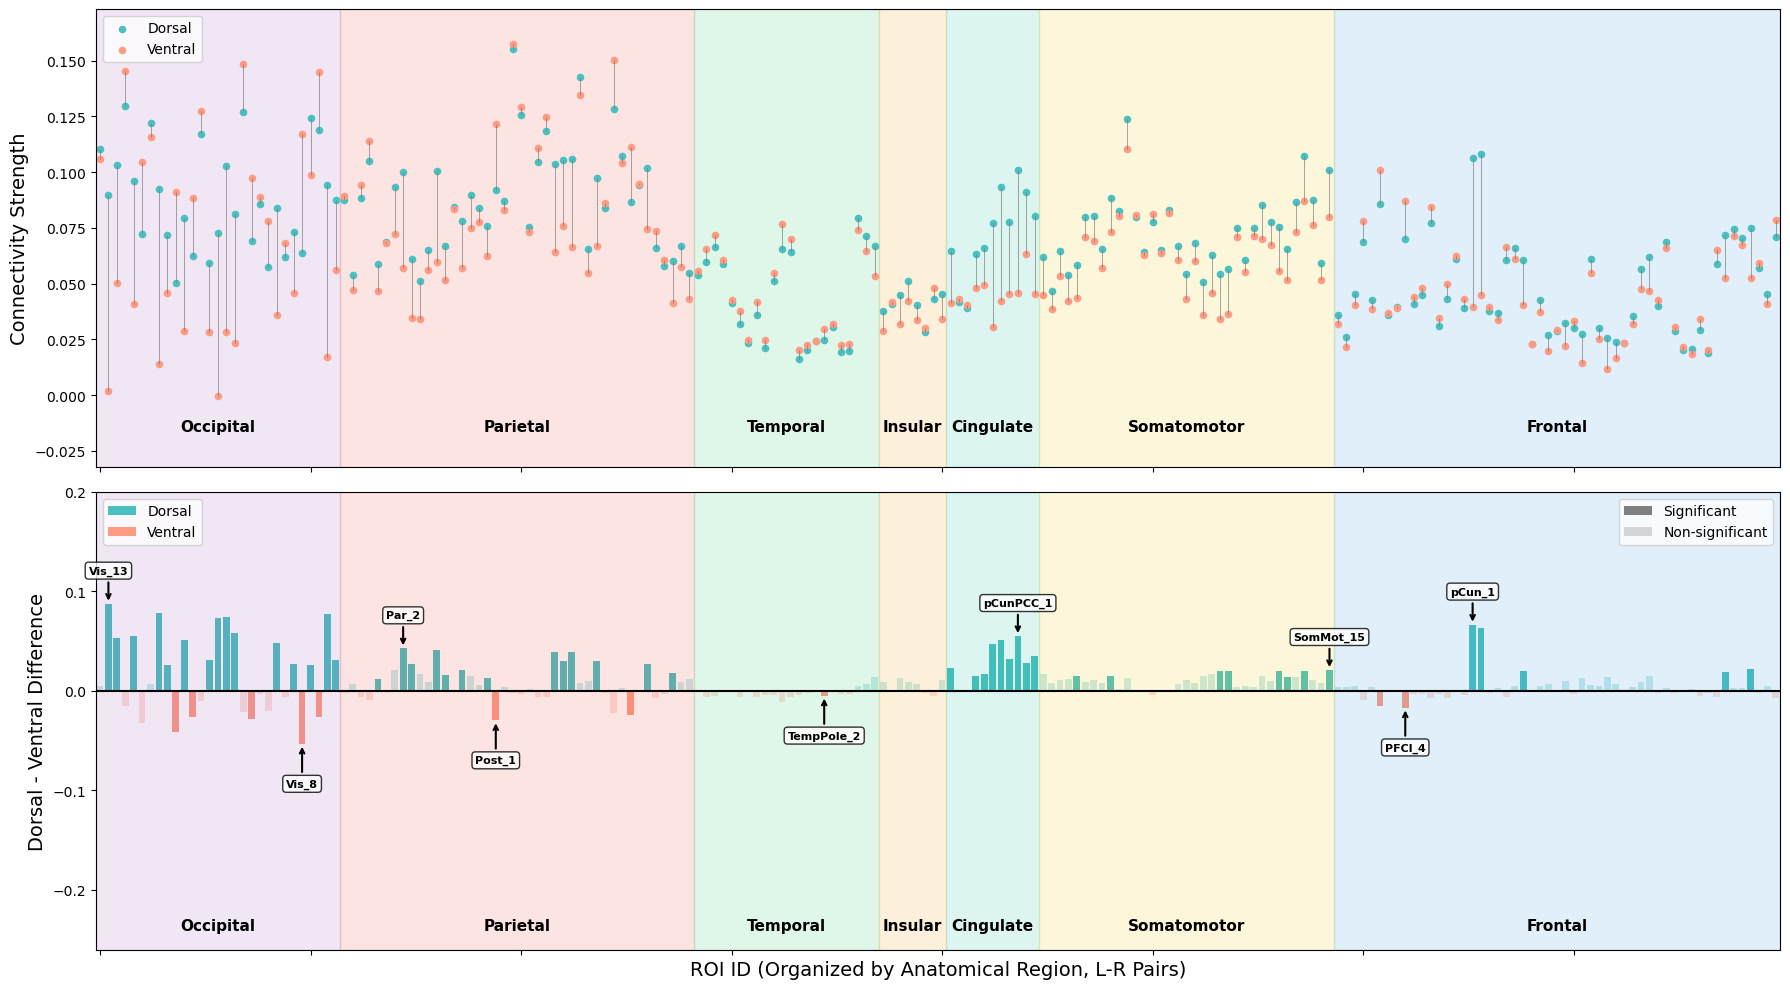

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/dice_comparison/fc_anatomical_organization.png

FC significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_13, Diff = 0.088
  Bottom (LO > pIPS): Vis_8, Diff = -0.053

Parietal Lobe:
  Peak (pIPS > LO): Par_2, Diff = 0.043
  Bottom (LO > pIPS): Post_1, Diff = -0.030

Temporal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): TempPole_2, Diff = -0.005

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_1, Diff = 0.055
  No significant LO-preferring ROIs in this lobe

Somatomotor Lobe:
  Peak (pIPS > LO): SomMot_15, Diff = 0.021
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): pCun_1, Diff = 0.067
  Bottom (LO > pIPS): PFCl_4, Diff = -0.017


In [26]:
# Cell 6: Create FC Visualization
# Load and visualize FC data
fc_results, fc_data = load_data_for_visualization('fc')
if fc_results is not None and fc_data is not None:
    visualize_anatomical_organization(fc_results, fc_data, analysis_type='fc')

Loaded PPI data with 200 ROIs

Creating PPI anatomical organization visualization...


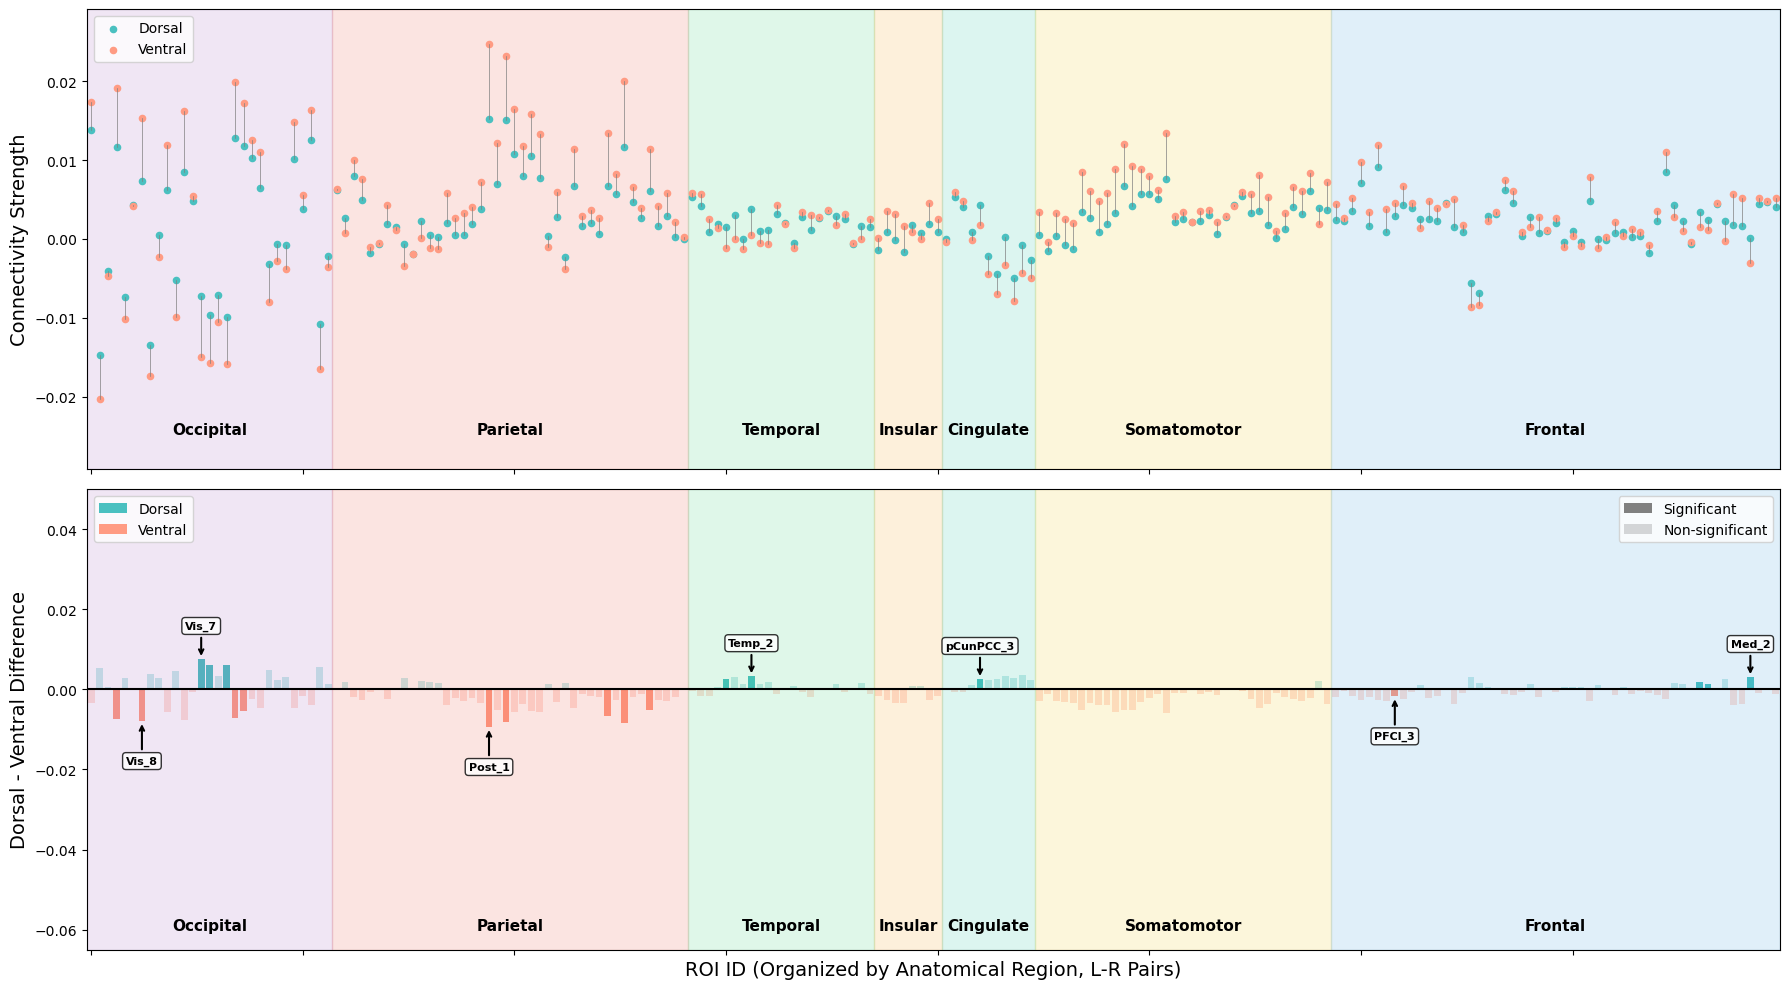

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/ppi_anatomical_organization.png

PPI significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_7, Diff = 0.008
  Bottom (LO > pIPS): Vis_8, Diff = -0.008

Parietal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): Post_1, Diff = -0.009

Temporal Lobe:
  Peak (pIPS > LO): Temp_2, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_3, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): Med_2, Diff = 0.003
  Bottom (LO > pIPS): PFCl_3, Diff = -0.002


In [32]:
# Cell 7: Create PPI Visualization
# Load and visualize PPI data
ppi_results, ppi_data = load_data_for_visualization('ppi')
if ppi_results is not None and ppi_data is not None:
    visualize_anatomical_organization(ppi_results, ppi_data, analysis_type='ppi')

## Dice Coefficient

In [11]:
# Cell 8: Dice Coefficient Function
def dice_coefficient(img1_data, img2_data):
    """Calculate Dice coefficient between two binary arrays."""
    # Ensure binary
    img1_bin = (img1_data > 0).astype(int)
    img2_bin = (img2_data > 0).astype(int)
    
    # Calculate intersection
    intersection = np.sum(img1_bin * img2_bin)
    
    # Calculate Dice using formula: 2*intersection/(sum of elements)
    dice = 2.0 * intersection / (np.sum(img1_bin) + np.sum(img2_bin))
    
    return dice

In [ ]:
# Cell 9: Function to Analyze Dice Coefficients for FC and PPI
def analyze_dice_coefficients(analysis_type):
    """Analyze dice coefficients for a specific data type (fc or ppi)"""
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} DICE COEFFICIENTS")
    print(f"{'='*80}")
    
    # Define paths - use the same paths as in the main script
    study_dir = "/lab_data/behrmannlab/vlad/ptoc"
    sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
    output_dir = f'{results_dir}/dice_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    # Load subject info
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    
    # Exclude sub-084 as specified
    if 'sub-084' in subjects:
        subjects.remove('sub-084')
        print("Excluded sub-084 from analysis")
    
    print(f"Found {len(subjects)} control subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                roi_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemi}_loc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        import nibabel as nib
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = avg_data
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Calculate Dice coefficient
            dice_score = dice_coefficient(subject_data[sub]['pIPS'], subject_data[sub]['LO'])
            
            between_roi_results.append({
                'Subject': sub,
                'Analysis': analysis_type,
                'Dice': dice_score
            })
            
            print(f"Subject {sub}, {analysis_type}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # Convert to DataFrame
    between_roi_df = pd.DataFrame(between_roi_results)
    
    # Calculate statistics
    from scipy import stats
    
    mean = between_roi_df['Dice'].mean()
    std = between_roi_df['Dice'].std()
    # 95% confidence interval
    ci = stats.t.interval(0.95, len(between_roi_df)-1, loc=mean, scale=std/np.sqrt(len(between_roi_df)))
    
    print(f"\n{analysis_type.upper()}: pIPS vs LO within-subject similarity:")
    print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
    print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
    print(f"N = {len(between_roi_df)} subjects")
    
    # 2. Between-subject, within-ROI analysis
    print(f"\nCalculating between-subject, within-ROI dice coefficients for {analysis_type}...")
    within_roi_results = {roi: [] for roi in rois}
    
    for roi in rois:
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Calculate Dice coefficient
                        dice_score = dice_coefficient(subject_data[sub1][roi], subject_data[sub2][roi])
                        
                        within_roi_results[roi].append({
                            'Subject1': sub1,
                            'Subject2': sub2,
                            'Dice': dice_score
                        })
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # Calculate statistics for each ROI
    roi_stats = {}
    
    for roi in rois:
        roi_df = pd.DataFrame(within_roi_results[roi])
        
        if len(roi_df) > 0:
            mean = roi_df['Dice'].mean()
            std = roi_df['Dice'].std()
            # 95% confidence interval
            ci = stats.t.interval(0.95, len(roi_df)-1, loc=mean, scale=std/np.sqrt(len(roi_df)))
            
            roi_stats[roi] = {
                'Mean': mean,
                'Std': std,
                'CI_Lower': ci[0],
                'CI_Upper': ci[1],
                'N': len(roi_df)
            }
            
            print(f"\n{analysis_type.upper()}: {roi} between-subject similarity:")
            print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
            print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
            print(f"Based on {len(roi_df)} comparisons among {len(valid_subjects)} subjects")
    
    # Save results to CSV files
    between_roi_df.to_csv(f'{output_dir}/{analysis_type}_between_roi_dice_by_subject.csv', index=False)
    
    for roi in rois:
        pd.DataFrame(within_roi_results[roi]).to_csv(
            f'{output_dir}/{roi}_{analysis_type}_between_subject_dice.csv', index=False)
    
    # The function returns all computed data
    return {
        'between_roi_df': between_roi_df,
        'within_roi_results': within_roi_results,
        'roi_stats': roi_stats
    }

In [13]:
# Cell 10: Calculate Dice Coefficients for FC and PPI
# Run the dice coefficient analysis for both FC and PPI
fc_dice_results = analyze_dice_coefficients('fc')
ppi_dice_results = analyze_dice_coefficients('ppi')

# Rename output files to match what the visualization expects
import shutil
output_dir = f'{results_dir}/dice_comparison'

# Rename the between-subject files if needed for compatibility with the visualization script
for src, dst in [
    (f'{output_dir}/fc_between_roi_dice_by_subject.csv', f'{output_dir}/between_roi_dice_by_subject.csv'),
    (f'{output_dir}/pIPS_fc_between_subject_dice.csv', f'{output_dir}/pIPS_between_subject_dice.csv'),
    (f'{output_dir}/LO_fc_between_subject_dice.csv', f'{output_dir}/LO_between_subject_dice.csv')
]:
    if os.path.exists(src) and not os.path.exists(dst):
        shutil.copy(src, dst)


ANALYZING FC DICE COEFFICIENTS
Excluded sub-084 from analysis
Found 18 control subjects
Found 18 subjects with complete fc data

Calculating within-subject, between-ROI dice coefficients for fc...
Subject sub-025, fc, pIPS vs LO: 0.7674
Subject sub-038, fc, pIPS vs LO: 0.8994
Subject sub-057, fc, pIPS vs LO: 0.9702
Subject sub-059, fc, pIPS vs LO: 0.9561
Subject sub-064, fc, pIPS vs LO: 0.8788
Subject sub-067, fc, pIPS vs LO: 0.9832
Subject sub-068, fc, pIPS vs LO: 0.9224
Subject sub-071, fc, pIPS vs LO: 0.9688
Subject sub-083, fc, pIPS vs LO: 0.9507
Subject sub-085, fc, pIPS vs LO: 0.8597
Subject sub-087, fc, pIPS vs LO: 0.9086
Subject sub-088, fc, pIPS vs LO: 0.9605
Subject sub-093, fc, pIPS vs LO: 0.9523
Subject sub-094, fc, pIPS vs LO: 0.8894
Subject sub-095, fc, pIPS vs LO: 0.9449
Subject sub-096, fc, pIPS vs LO: 0.9090
Subject sub-097, fc, pIPS vs LO: 0.8686
Subject sub-107, fc, pIPS vs LO: 0.8695

FC: pIPS vs LO within-subject similarity:
Mean Dice: 0.9144 ± 0.0539
95% CI: [0.8


Dice Coefficient Plot Interpretation:
- Within-subject: Average overlap between dorsal and ventral connectivity maps in the same individual
- Between-subjects: Average overlap when comparing the same region across different individuals
- Higher values indicate greater similarity in connectivity patterns

Saved FC visualization to: /user_data/csimmon2/git_repos/ptoc/results/dice_comparison/fc_dice_coefficient_violin.png


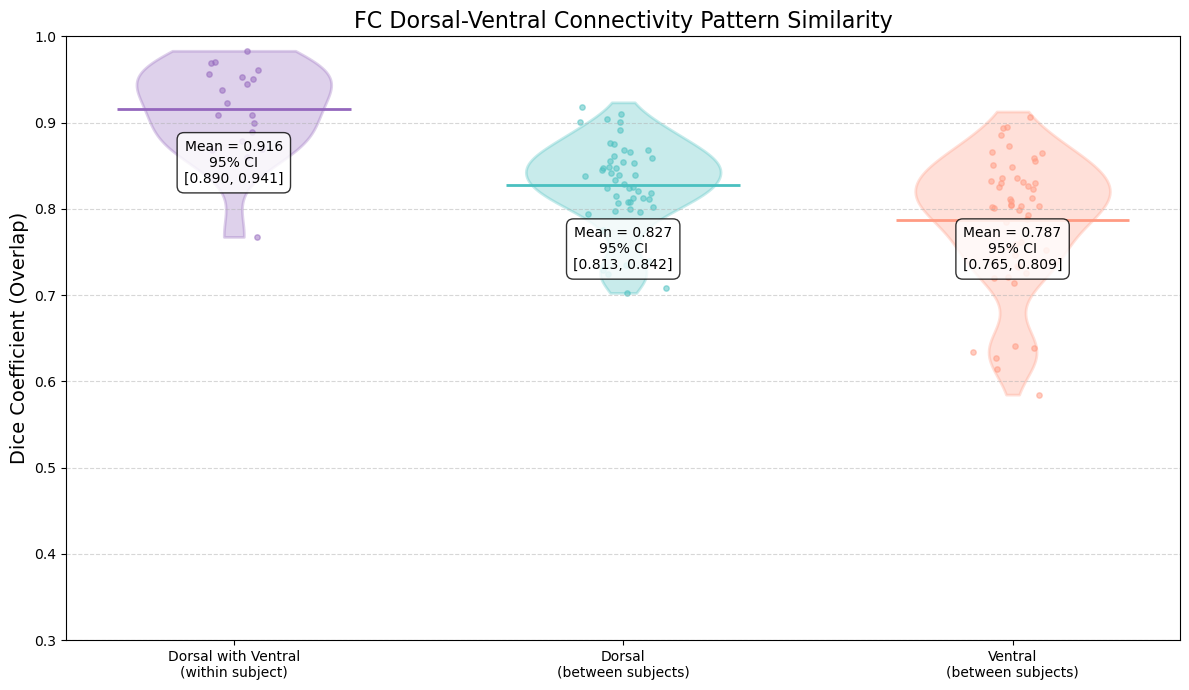

Saved PPI visualization to: /user_data/csimmon2/git_repos/ptoc/results/dice_comparison/ppi_dice_coefficient_violin.png


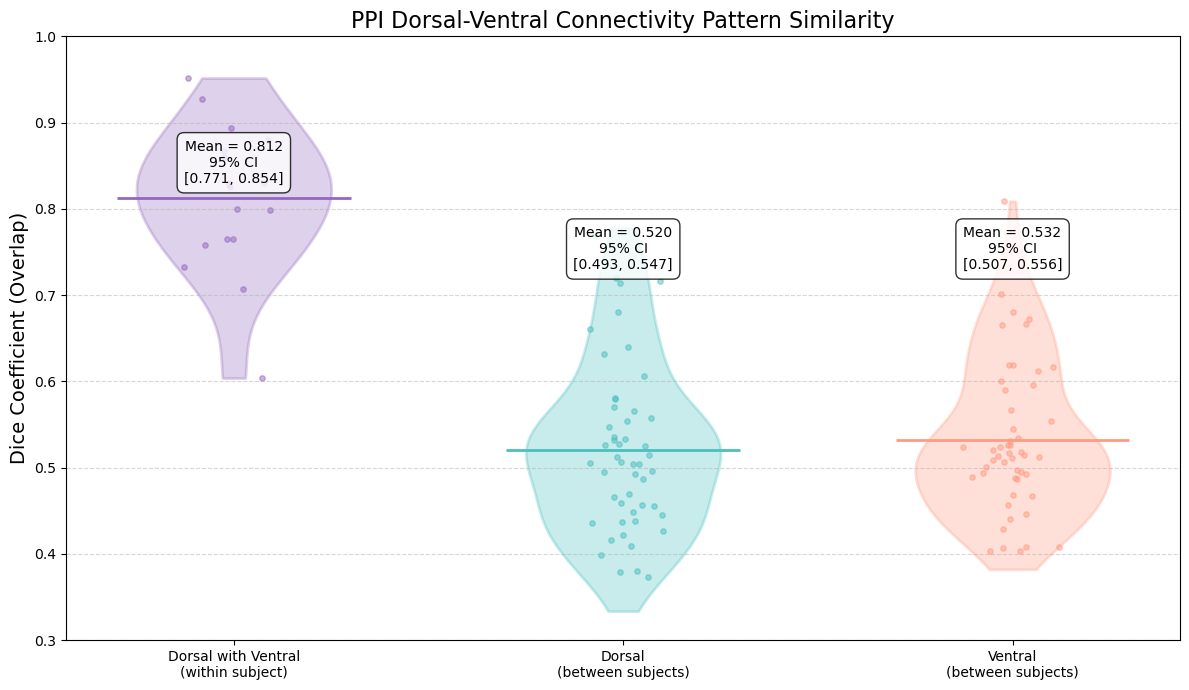

In [12]:
# Cell 11: Create Violin Plots for Both FC and PPI Dice Coefficients
import seaborn as sns
from scipy import stats

# temp for this cell only.
output_dir = f'{results_dir}/dice_comparison'

# Function to create violin plot for a specific analysis type
def create_dice_violin_plot(analysis_type):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define file paths with correct prefixes
    prefix = "" if analysis_type == 'fc' else f"{analysis_type}_"
    
    # Load the data from saved CSVs
    between_roi_data = pd.read_csv(f'{output_dir}/{prefix}between_roi_dice_by_subject.csv')
    pips_data = pd.read_csv(f'{output_dir}/pIPS_{analysis_type}_between_subject_dice.csv')
    lo_data = pd.read_csv(f'{output_dir}/LO_{analysis_type}_between_subject_dice.csv')
    
    # Prepare data in the format needed for seaborn
    plot_data = []
    
    # Add within-subject data (pIPS with LO)
    for _, row in between_roi_data.iterrows():
        plot_data.append({
            'Comparison': 'Dorsal with Ventral\n(within subject)',
            'Dice': row['Dice']
        })
    
    # Add between-subject data for pIPS
    for _, row in pips_data.iterrows():
        plot_data.append({
            'Comparison': 'Dorsal\n(between subjects)',
            'Dice': row['Dice']
        })
    
    # Add between-subject data for LO
    for _, row in lo_data.iterrows():
        plot_data.append({
            'Comparison': 'Ventral\n(between subjects)',
            'Dice': row['Dice']
        })
    
    # Convert to DataFrame
    violin_df = pd.DataFrame(plot_data)
    
    # Define the order of comparisons
    order = ['Dorsal with Ventral\n(within subject)', 'Dorsal\n(between subjects)', 'Ventral\n(between subjects)']
    
    # Define colors with correct assignments
    color_map = {
        'Dorsal with Ventral\n(within subject)': '#9467bd',  # Purple for within subject
        'Dorsal\n(between subjects)': '#4ac0c0',      # Teal for pIPS
        'Ventral\n(between subjects)': '#ff9b83'         # Peach for LO
    }
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Loop through each category to create custom violins
    for i, comp in enumerate(order):
        # Get data for this comparison
        comp_data = violin_df[violin_df['Comparison'] == comp]['Dice']
        
        # Calculate violin data using custom function
        parts = ax.violinplot(comp_data, positions=[i], showmeans=False, 
                             showmedians=False, showextrema=False)
        
        # Set colors directly for this violin
        for pc in parts['bodies']:
            # Set the outline to the original color
            pc.set_edgecolor(color_map[comp])
            # Set the fill to a transparent version
            rgb = plt.cm.colors.to_rgb(color_map[comp])
            pc.set_facecolor((*rgb, 0.3))  # 30% opacity
            # Make the line thicker
            pc.set_linewidth(2)
        
        # For the between-subject comparisons, limit points to avoid overcrowding
        if 'between subjects' in comp:
            # Take a random sample of points to avoid overcrowding
            if len(comp_data) > 50:
                comp_data = comp_data.sample(50, random_state=42)
        
        # Add jitter to x position to avoid overlapping points
        x_jitter = np.random.normal(0, 0.05, size=len(comp_data))
        plt.scatter(x=np.repeat(i, len(comp_data)) + x_jitter, 
                   y=comp_data, 
                   color=color_map[comp], alpha=0.5, s=15)
        
        # Calculate statistics for this comparison
        mean = comp_data.mean()
        ci = stats.t.interval(0.95, len(comp_data)-1, 
                              loc=mean, 
                              scale=comp_data.std()/np.sqrt(len(comp_data)))
        
        # Add mean line with matching color
        plt.hlines(y=mean, xmin=i-0.3, xmax=i+0.3, color=color_map[comp], linewidth=2)
        
        # Position annotations better
        if comp == 'Dorsal with Ventral\n(within subject)':
            y_pos = 0.83  # Lower position for within-subject
        else:
            y_pos = 0.73  # Higher position for between-subject
        
        plt.text(i, y_pos, f"Mean = {mean:.3f}\n95% CI\n[{ci[0]:.3f}, {ci[1]:.3f}]",
                horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Set x-tick labels
    plt.xticks(range(len(order)), order)
    
    # Customize the plot
    plt.ylabel('Dice Coefficient (Overlap)', fontsize=14)
    plt.title(f'{analysis_type.upper()} Dorsal-Ventral Connectivity Pattern Similarity', fontsize=16)
    plt.ylim([0.3, 1])  # Set y-axis from 0 to 1 as requested
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{output_dir}/{analysis_type}_dice_coefficient_violin.png', dpi=300, bbox_inches='tight')
    print(f"Saved {analysis_type.upper()} visualization to: {output_dir}/{analysis_type}_dice_coefficient_violin.png")
    
    # Display the plot
    plt.show()

# Print explanation separately rather than adding it to the figure
explanation = """
Dice Coefficient Plot Interpretation:
- Within-subject: Average overlap between dorsal and ventral connectivity maps in the same individual
- Between-subjects: Average overlap when comparing the same region across different individuals
- Higher values indicate greater similarity in connectivity patterns
"""
print(explanation)

# Create violin plots for both FC and PPI
for analysis_type in ['fc', 'ppi']:
    create_dice_violin_plot(analysis_type)


Dice Coefficient Plot Interpretation:
- Each semi-transparent bar represents the **mean Dice coefficient** for a specific comparison group.
- The black lines on top of each bar are the **95% Confidence Intervals (CI)**.
- **Within-subject**: Average overlap between dorsal and ventral connectivity maps in the same individual.
- **Between-subjects**: Average overlap when comparing the same region across different individuals.
- Higher values indicate greater similarity in connectivity patterns.



/tmp/ipykernel_1787518/575715910.py:76: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/tmp/ipykernel_1787518/575715910.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1787518/575715910.py:76: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(


Saved FC visualization to: /user_data/csimmon2/git_repos/ptoc/results/dice_comparison/fc_dice_coefficient_barplot.png


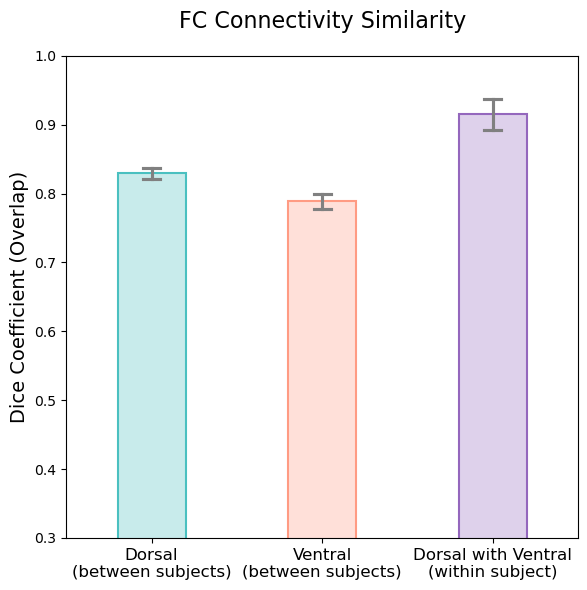

/tmp/ipykernel_1787518/575715910.py:76: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/tmp/ipykernel_1787518/575715910.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1787518/575715910.py:76: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(


Saved PPI visualization to: /user_data/csimmon2/git_repos/ptoc/results/dice_comparison/ppi_dice_coefficient_barplot.png


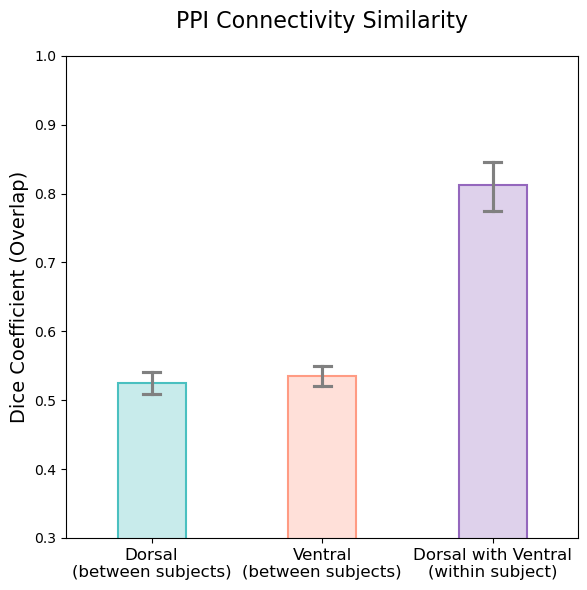

In [6]:
# Cell 11b: Create Bar Plots for Both FC and PPI Dice Coefficients
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import stats

# Assume results_dir is defined from a previous cell
# Example: results_dir = './results'
output_dir = f'{results_dir}/dice_comparison'

# Function to create a bar plot for a specific analysis type
def create_dice_barplot(analysis_type):
    """
    Generates and saves a simple bar plot comparing Dice coefficients for a given analysis type with semi-transparent colors.
    The plot shows the mean and 95% confidence interval for each category.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define file paths with correct prefixes
    prefix = "" if analysis_type == 'fc' else f"{analysis_type}_"
    
    # Load the data from saved CSVs
    try:
        between_roi_data = pd.read_csv(f'{output_dir}/{prefix}between_roi_dice_by_subject.csv')
        pips_data = pd.read_csv(f'{output_dir}/pIPS_{analysis_type}_between_subject_dice.csv')
        lo_data = pd.read_csv(f'{output_dir}/LO_{analysis_type}_between_subject_dice.csv')
    except FileNotFoundError as e:
        print(f"Error loading data for {analysis_type.upper()}: {e}")
        print("Please ensure the required CSV files are in the output directory.")
        return

    # Prepare data in a long format suitable for seaborn
    plot_data = []
    
    # Add within-subject data (pIPS with LO)
    for _, row in between_roi_data.iterrows():
        plot_data.append({
            'Comparison': 'Dorsal with Ventral\n(within subject)',
            'Dice': row['Dice']
        })
    
    # Add between-subject data for pIPS
    for _, row in pips_data.iterrows():
        plot_data.append({
            'Comparison': 'Dorsal\n(between subjects)',
            'Dice': row['Dice']
        })
    
    # Add between-subject data for LO
    for _, row in lo_data.iterrows():
        plot_data.append({
            'Comparison': 'Ventral\n(between subjects)',
            'Dice': row['Dice']
        })
    
    # Convert list of dictionaries to a DataFrame
    plot_df = pd.DataFrame(plot_data)
    
    # Define the order for the categories on the x-axis
    order = ['Dorsal\n(between subjects)', 'Ventral\n(between subjects)', 'Dorsal with Ventral\n(within subject)']
    
    # Define the color mapping for each category
    color_map = {
        'Dorsal with Ventral\n(within subject)': '#9467bd',  # Purple
        'Dorsal\n(between subjects)': '#4ac0c0',              # Teal
        'Ventral\n(between subjects)': '#ff9b83'              # Peach
    }
    
    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Create the main bar plot using seaborn.barplot()
    sns.barplot(
        x='Comparison', 
        y='Dice', 
        data=plot_df, 
        order=order, 
        palette=color_map, 
        ax=ax,
        ci=95,  # Automatically calculates and plots the 95% CI
        capsize=0.1,  # Adds small caps to the error bars
        errcolor='gray', # Sets the color of the error bars
        width=0.4 # Makes the bars narrower
    )
    
    # --- Corrected logic to set semi-transparent bar colors ---
    for i, bar in enumerate(ax.patches):
        color = color_map[order[i]]
        rgb = plt.cm.colors.to_rgb(color)
        bar.set_facecolor((*rgb, 0.3)) # Set face color with 30% opacity
        bar.set_edgecolor(color)       # Keep the original outline color
        bar.set_linewidth(1.5)
    
    # --- REMOVED: Mean and CI Text Annotations at the Base ---
    # The following block has been commented out to remove the text box
    # for i, comp in enumerate(order):
    #     comp_data = plot_df[plot_df['Comparison'] == comp]['Dice']
    #     mean = comp_data.mean()
    #     ci = stats.t.interval(0.95, len(comp_data)-1, loc=mean, scale=stats.sem(comp_data))
    #     
    #     # Position the text annotation just above the x-axis, at the base of the bar
    #     y_pos = 0.35  # Adjust this value as needed to fit the plot
    #     
    #     ax.text(i, y_pos, f"Mean = {mean:.3f}\n95% CI\n[{ci[0]:.3f}, {ci[1]:.3f}]",
    #             horizontalalignment='center',
    #             fontsize=9,
    #             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # --- Final Plot Customization ---
    ax.set_ylabel('Dice Coefficient (Overlap)', fontsize=14)
    ax.set_xlabel('')  # Remove x-axis label as category labels are clear
    ax.set_title(f'{analysis_type.upper()} Connectivity Similarity', fontsize=16, pad=20)
    ax.set_ylim([0.3, 1.0])
    
    # Ensure x-tick labels are readable
    plt.xticks(fontsize=12)
    
    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()
    
    # Save the figure
    save_path = f'{output_dir}/{analysis_type}_dice_coefficient_barplot.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved {analysis_type.upper()} visualization to: {save_path}")
    
    # Display the plot
    plt.show()

# --- Execution ---
# Print the interpretation guide for the plots
explanation = """
Dice Coefficient Plot Interpretation:
- Each semi-transparent bar represents the **mean Dice coefficient** for a specific comparison group.
- The black lines on top of each bar are the **95% Confidence Intervals (CI)**.
- **Within-subject**: Average overlap between dorsal and ventral connectivity maps in the same individual.
- **Between-subjects**: Average overlap when comparing the same region across different individuals.
- Higher values indicate greater similarity in connectivity patterns.
"""
print(explanation)

# Generate and display the bar plots for both FC and PPI analyses
for analysis_type in ['fc', 'ppi']:
    create_dice_barplot(analysis_type)

In [13]:
# accidentally deleted original analysis script for DICE rmANOVA. here's an attempted recreation see: abb7914 being_verified/paper_content/sim+diff_ex1.ipynb
# Cell 12: Repeated Measures ANOVA for Dice Coefficients
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests

def run_dice_rmanova(analysis_type='fc'):
    """
    Run repeated measures ANOVA on dice coefficients
    Uses data already saved from previous analysis
    """
    print(f"\n{'='*80}")
    print(f"REPEATED MEASURES ANOVA FOR {analysis_type.upper()} DICE COEFFICIENTS")
    print(f"{'='*80}")
    
    # Load the data from saved CSVs
    output_dir = f'{results_dir}/dice_comparison'
    
    # Load within-subject data
    between_roi_df = pd.read_csv(f'{output_dir}/{analysis_type}_between_roi_dice_by_subject.csv')
    
    # Load between-subject pairwise data
    pips_pairs = pd.read_csv(f'{output_dir}/pIPS_{analysis_type}_between_subject_dice.csv')
    lo_pairs = pd.read_csv(f'{output_dir}/LO_{analysis_type}_between_subject_dice.csv')
    
    # Calculate per-subject averages for between-subject comparisons
    subjects = between_roi_df['Subject'].unique()
    
    # Create dictionaries to store averages
    pips_averages = {}
    lo_averages = {}
    
    for sub in subjects:
        # Get all pairwise comparisons involving this subject
        pips_with_sub = pips_pairs[(pips_pairs['Subject1'] == sub) | (pips_pairs['Subject2'] == sub)]
        lo_with_sub = lo_pairs[(lo_pairs['Subject1'] == sub) | (lo_pairs['Subject2'] == sub)]
        
        # Calculate average (each subject's average similarity to all others)
        pips_averages[sub] = pips_with_sub['Dice'].mean()
        lo_averages[sub] = lo_with_sub['Dice'].mean()
    
    # Create repeated measures data structure
    rm_data = []
    for sub in subjects:
        # Within-subject dice
        within_dice = between_roi_df[between_roi_df['Subject'] == sub]['Dice'].values[0]
        
        # Add three rows per subject
        rm_data.append({'Subject': sub, 'Condition': 'Within-subject', 'Dice': within_dice})
        rm_data.append({'Subject': sub, 'Condition': 'Between-dorsal', 'Dice': pips_averages[sub]})
        rm_data.append({'Subject': sub, 'Condition': 'Between-ventral', 'Dice': lo_averages[sub]})
    
    rm_df = pd.DataFrame(rm_data)
    
    # Calculate and display means
    means = rm_df.groupby('Condition')['Dice'].agg(['mean', 'std', 'count'])
    print("\nCondition Means:")
    print(means)
    
    # Run repeated measures ANOVA
    rm_anova = AnovaRM(rm_df, 'Dice', 'Subject', within=['Condition'])
    rm_results = rm_anova.fit()
    print("\n" + str(rm_results))
    
    # Extract statistics
    f_stat = rm_results.anova_table['F Value'].iloc[0]
    p_val = rm_results.anova_table['Pr > F'].iloc[0]
    df_num = rm_results.anova_table['Num DF'].iloc[0]
    df_den = rm_results.anova_table['Den DF'].iloc[0]
    
    print(f"\nMain effect: F({df_num:.0f}, {df_den:.0f}) = {f_stat:.2f}, p < .001")
    
    # Post-hoc paired t-tests
    print("\n" + "="*60)
    print("POST-HOC COMPARISONS (Holm-Bonferroni corrected)")
    print("="*60)
    
    # Prepare data for pairwise comparisons
    within_data = rm_df[rm_df['Condition'] == 'Within-subject']['Dice'].values
    dorsal_data = rm_df[rm_df['Condition'] == 'Between-dorsal']['Dice'].values
    ventral_data = rm_df[rm_df['Condition'] == 'Between-ventral']['Dice'].values
    
    comparisons = [
        ('Within-subject vs Between-dorsal', within_data, dorsal_data),
        ('Within-subject vs Between-ventral', within_data, ventral_data),
        ('Between-dorsal vs Between-ventral', dorsal_data, ventral_data)
    ]
    
    p_values = []
    t_stats = []
    
    for name, data1, data2 in comparisons:
        t_stat, p_val = stats.ttest_rel(data1, data2)
        p_values.append(p_val)
        t_stats.append(t_stat)
    
    # Apply Holm-Bonferroni correction
    reject, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')
    
    # Display results
    for i, (name, _, _) in enumerate(comparisons):
        # Format p-value according to manuscript guidelines
        if p_corrected[i] < 0.001:
            p_str = "p < .001"
        else:
            p_str = f"p = {p_corrected[i]:.3f}"
        
        significance = "***" if reject[i] else "ns"
        print(f"\n{name}:")
        print(f"  t({len(within_data)-1}) = {t_stats[i]:.3f}")
        print(f"  {p_str} {significance}")
    
    # Save results
    results_summary = pd.DataFrame({
        'Comparison': [c[0] for c in comparisons],
        't_statistic': t_stats,
        'p_uncorrected': p_values,
        'p_corrected': p_corrected,
        'significant': reject
    })
    
    try:
        results_summary.to_csv(f'{output_dir}/{analysis_type}_rmanova_posthoc.csv', index=False)
        print(f"\nResults saved to {output_dir}/{analysis_type}_rmanova_posthoc.csv")
    except:
        print(f"\nNote: Could not save CSV due to pandas version compatibility")
    
    return rm_results, results_summary

# Run for both FC and PPI
print("\n" + "="*80)
print("DICE COEFFICIENT STATISTICAL ANALYSES")
print("="*80)

fc_rmanova, fc_posthoc = run_dice_rmanova('fc')
ppi_rmanova, ppi_posthoc = run_dice_rmanova('ppi')


DICE COEFFICIENT STATISTICAL ANALYSES

REPEATED MEASURES ANOVA FOR FC DICE COEFFICIENTS

Condition Means:
                     mean       std  count
Condition                                 
Between-dorsal   0.829965  0.034159     18
Between-ventral  0.788543  0.050596     18
Within-subject   0.914417  0.053851     18

                 Anova
          F Value  Num DF  Den DF Pr > F
----------------------------------------
Condition 194.9838 2.0000 34.0000 0.0000


Main effect: F(2, 34) = 194.98, p < .001

POST-HOC COMPARISONS (Holm-Bonferroni corrected)

Within-subject vs Between-dorsal:
  t(17) = 10.774
  p < .001 ***

Within-subject vs Between-ventral:
  t(17) = 20.608
  p < .001 ***

Between-dorsal vs Between-ventral:
  t(17) = 7.843
  p < .001 ***

Note: Could not save CSV due to pandas version compatibility

REPEATED MEASURES ANOVA FOR PPI DICE COEFFICIENTS


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))



Condition Means:
                     mean       std  count
Condition                                 
Between-dorsal   0.525189  0.068652     18
Between-ventral  0.534656  0.061305     18
Within-subject   0.812384  0.083633     18

                 Anova
          F Value  Num DF  Den DF Pr > F
----------------------------------------
Condition 298.3852 2.0000 34.0000 0.0000


Main effect: F(2, 34) = 298.39, p < .001

POST-HOC COMPARISONS (Holm-Bonferroni corrected)


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))



Within-subject vs Between-dorsal:
  t(17) = 20.311
  p < .001 ***

Within-subject vs Between-ventral:
  t(17) = 17.399
  p < .001 ***

Between-dorsal vs Between-ventral:
  t(17) = -1.055
  p = 0.306 ns

Note: Could not save CSV due to pandas version compatibility


Loaded FC data with 200 ROIs

Creating FC anatomical organization visualization...


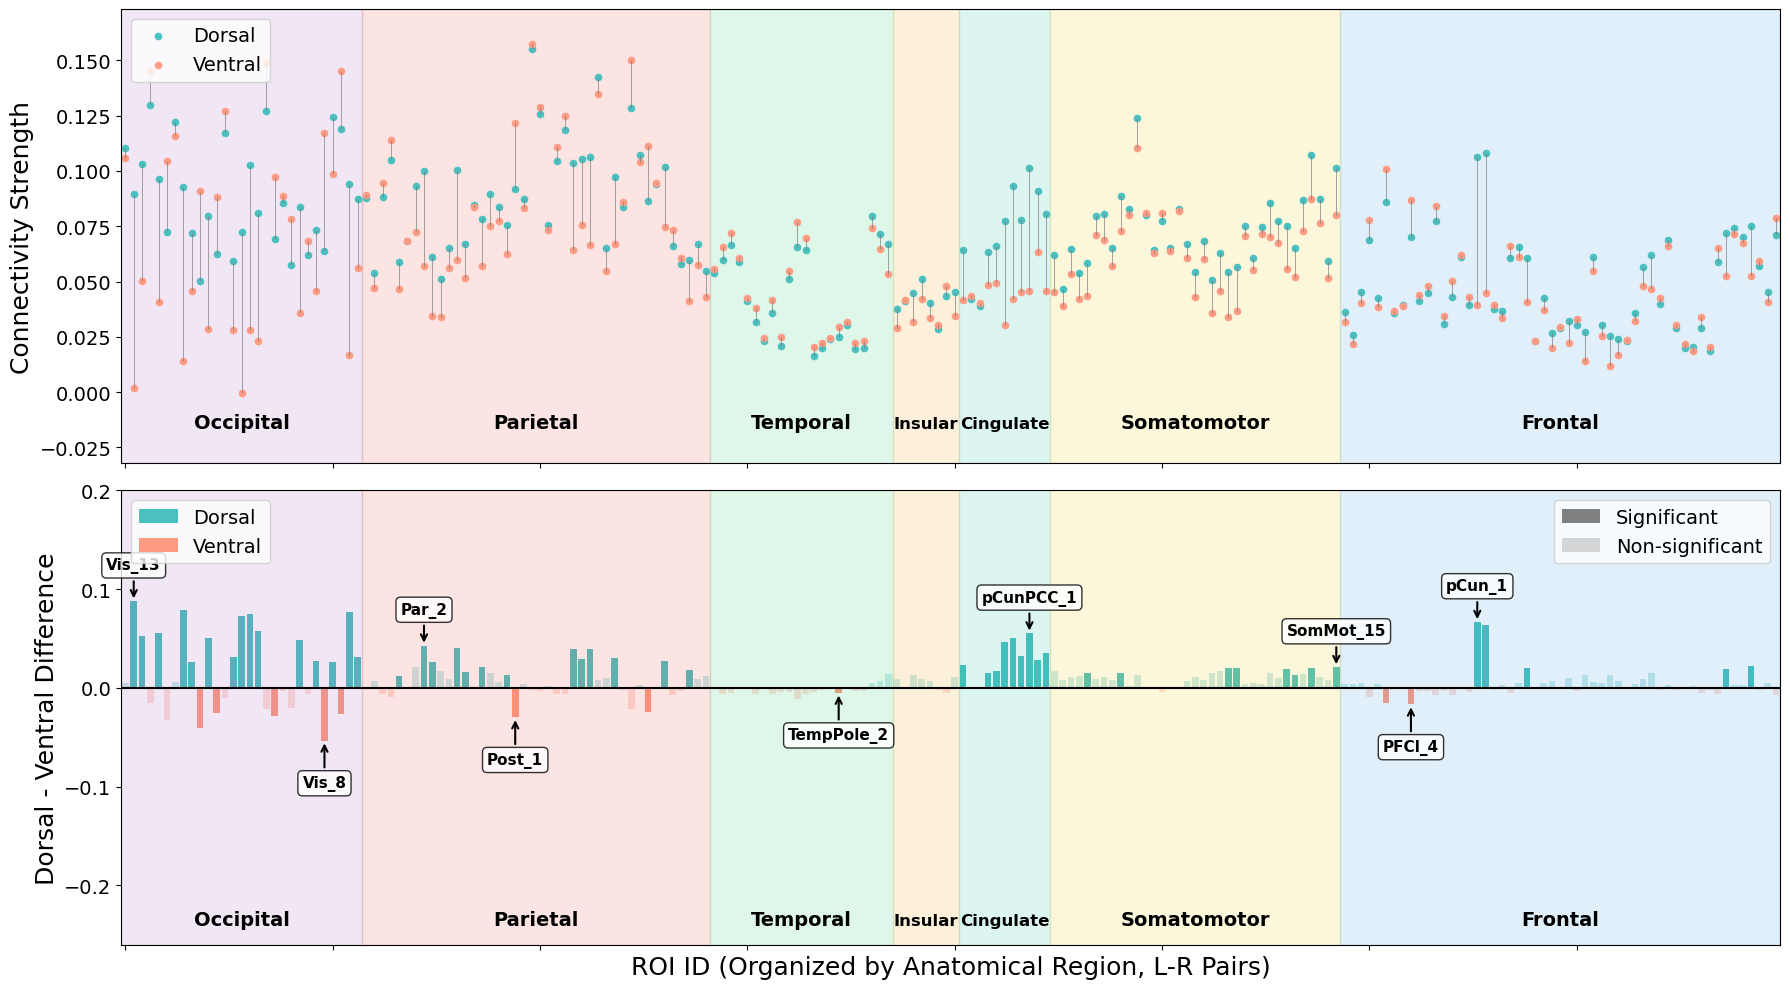

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/fc_anatomical_organization.png

FC significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_13, Diff = 0.088
  Bottom (LO > pIPS): Vis_8, Diff = -0.053

Parietal Lobe:
  Peak (pIPS > LO): Par_2, Diff = 0.043
  Bottom (LO > pIPS): Post_1, Diff = -0.030

Temporal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): TempPole_2, Diff = -0.005

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_1, Diff = 0.055
  No significant LO-preferring ROIs in this lobe

Somatomotor Lobe:
  Peak (pIPS > LO): SomMot_15, Diff = 0.021
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): pCun_1, Diff = 0.067
  Bottom (LO > pIPS): PFCl_4, Diff = -0.017
Loaded PPI data with 200 ROIs

Creating PPI anatomical organization visualization...


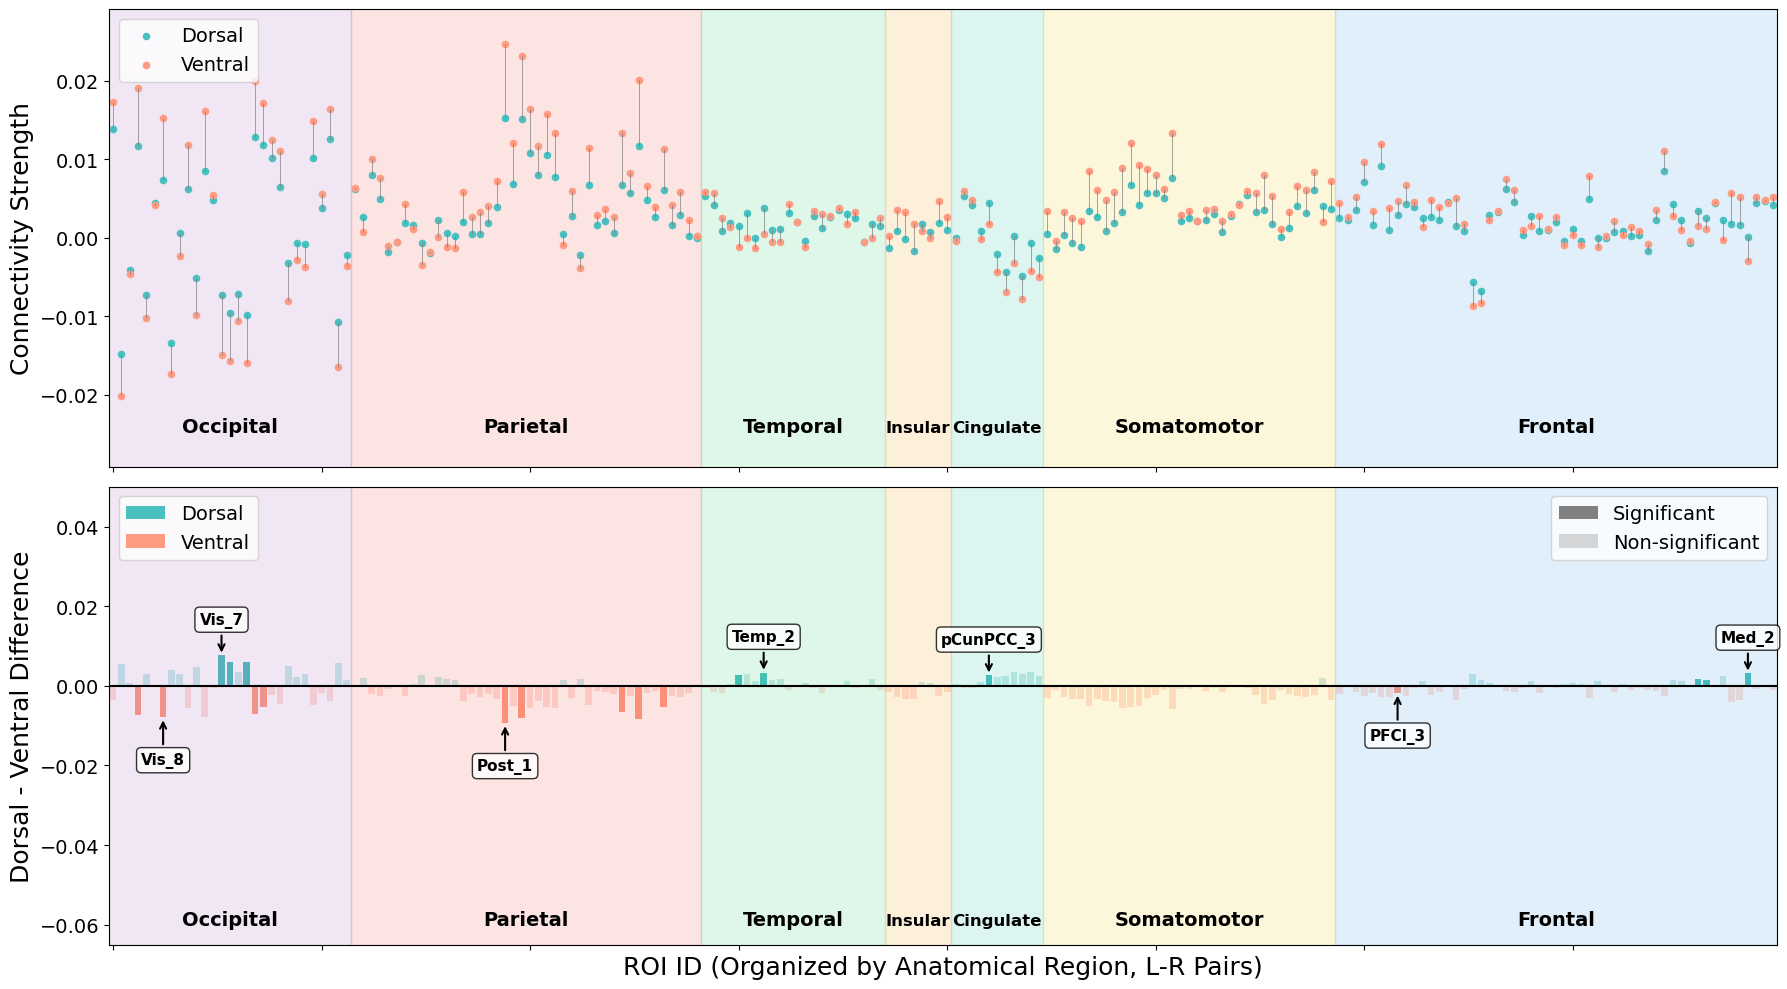

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/ppi_anatomical_organization.png

PPI significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_7, Diff = 0.008
  Bottom (LO > pIPS): Vis_8, Diff = -0.008

Parietal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): Post_1, Diff = -0.009

Temporal Lobe:
  Peak (pIPS > LO): Temp_2, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_3, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): Med_2, Diff = 0.003
  Bottom (LO > pIPS): PFCl_3, Diff = -0.002


In [7]:
# Standalone cell for FC and PPI visualization

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch

# Define paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_comparison'
os.makedirs(output_dir, exist_ok=True)

# Helper functions
def map_to_anatomical_lobe(roi_name):
    """Map ROI names to anatomical lobes"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'Wang_pIPS' in roi_name:
        return 'Parietal'
    elif 'Wang_LO' in roi_name:
        return 'Temporal'
    
    if 'Vis' in roi_name:
        return 'Occipital'
    elif 'SomMot' in roi_name:
        return 'Somatomotor'
    elif 'DorsAttn' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        else:
            return 'Parietal'
    elif 'SalVentAttn' in roi_name:
        if 'Ins' in roi_name:
            return 'Insular'
        elif 'Cing' in roi_name or 'ACC' in roi_name:
            return 'Cingulate'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'Par' in roi_name:
            return 'Parietal'
        else:
            return 'Frontal'
    elif 'Limbic' in roi_name:
        if 'Temp' in roi_name:
            return 'Temporal'
        else:
            return 'Frontal'
    elif 'Cont' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        elif 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    elif 'Default' in roi_name:
        if 'Par' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'PCC' in roi_name or 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    else:
        return 'Other'

def clean_roi_name(roi_name):
    """Clean up ROI names for better labeling"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'Wang_' in roi_name:
        return roi_name.replace('Wang_', '')
    
    cleaned = roi_name.replace('7Networks_', '')
    
    parts = cleaned.split('_')
    if len(parts) > 2:
        return parts[-2] + '_' + parts[-1]
    elif len(parts) > 1:
        return parts[-1]
    else:
        return cleaned

def get_hemisphere_and_region(roi_name):
    """Determine hemisphere and base region for organizing pairs"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'LH' in roi_name:
        hemisphere = 'L'
    elif 'RH' in roi_name:
        hemisphere = 'R'
    else:
        if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
            hemisphere = 'X'
        else:
            hemisphere = 'X'
    
    cleaned = roi_name.replace('7Networks_', '')
    cleaned = cleaned.replace('LH_', '').replace('RH_', '')
    
    if 'Wang_' in cleaned:
        base_region = cleaned.replace('Wang_', '')
    else:
        base_region = re.sub(r'_\d+$', '', cleaned)
    
    return hemisphere, base_region

def load_data_for_visualization(analysis_type='fc'):
    """Load data from CSV and prepare it for visualization"""
    csv_path = f'{output_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    
    if not os.path.exists(csv_path):
        print(f"Error: {analysis_type.upper()} results file not found at {csv_path}")
        return None, None
        
    results_df = pd.read_csv(csv_path)
    print(f"Loaded {analysis_type.upper()} data with {len(results_df)} ROIs")
    
    roi_data = {
        'mean_pips': results_df['pIPS_Connectivity'].values,
        'mean_lo': results_df['LO_Connectivity'].values,
        'diff_profile': results_df['Difference'].values,
        'ci_lower': results_df['CI_Lower'].values,
        'ci_upper': results_df['CI_Upper'].values,
        'sig_combined': results_df['Combined_Significant'].values
    }
    
    return results_df, roi_data

def visualize_anatomical_organization(results_df, roi_data, analysis_type='fc'):
    """Create anatomical organization visualization"""
    print(f"\nCreating {analysis_type.upper()} anatomical organization visualization...")
    
    mean_pips = roi_data['mean_pips']
    mean_lo = roi_data['mean_lo']
    diff_profile = roi_data['diff_profile']
    ci_lower = roi_data['ci_lower']
    ci_upper = roi_data['ci_upper']
    sig_combined = roi_data['sig_combined']
    
    results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
    results_df['Clean_Name'] = results_df['ROI_Name'].apply(clean_roi_name)
    
    hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
    results_df['Hemisphere'] = [h for h, r in hemisphere_region]
    results_df['Base_Region'] = [r for h, r in hemisphere_region]
    
    lobe_order = [
        'Occipital',
        'Parietal',
        'Temporal',
        'Insular',
        'Cingulate',
        'Somatomotor',
        'Frontal',
        'Other'
    ]
    
    lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
    results_df['Lobe_Sorted'] = lobe_cat
    
    lobe_colors = {
        'Frontal': '#3498db',
        'Somatomotor': '#f1c40f',
        'Parietal': '#e74c3c',
        'Temporal': '#2ecc71',
        'Occipital': '#9b59b6',
        'Insular': '#f39c12',
        'Cingulate': '#1abc9c',
        'Other': '#7f8c8d'
    }
    
    def custom_sort(row):
        lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
        hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
        return (lobe_idx, row['Base_Region'], hemi_idx)
    
    results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
    results_df_sorted = results_df.sort_values('sort_key')
    
    sorted_indices = results_df_sorted.index.values
    
    mean_pips_sorted = results_df_sorted['pIPS_Connectivity'].values
    mean_lo_sorted = results_df_sorted['LO_Connectivity'].values
    diff_profile_sorted = results_df_sorted['Difference'].values
    sig_sorted = results_df_sorted['Combined_Significant'].values
    
    significant_roi_positions = []
    lobe_sections = []
    
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                lobe_sections.append((current_lobe, start_idx, i-1))
            current_lobe = lobe
            start_idx = i
    
    if current_lobe is not None:
        lobe_sections.append((current_lobe, start_idx, len(sorted_indices)-1))
    
    for lobe, start, end in lobe_sections:
        section_indices = sorted_indices[start:end+1]
        section_diff = diff_profile_sorted[start:end+1]
        section_sig = sig_sorted[start:end+1]
        
        sig_positions = np.where(section_sig)[0]
        if len(sig_positions) > 0:
            sig_diffs = section_diff[sig_positions]
            
            if np.max(sig_diffs) > 0:
                max_sig_idx = sig_positions[np.argmax(sig_diffs)]
                significant_roi_positions.append(start + max_sig_idx)
            
            if np.min(sig_diffs) < 0:
                min_sig_idx = sig_positions[np.argmin(sig_diffs)]
                significant_roi_positions.append(start + min_sig_idx)
    
    plt.figure(figsize=(18, 10))
    
    ax1 = plt.subplot(2, 1, 1)
    x = np.arange(len(mean_pips_sorted))
    
    y_min, y_max = min(min(mean_pips_sorted), min(mean_lo_sorted)), max(max(mean_pips_sorted), max(mean_lo_sorted))
    y_range = y_max - y_min
    
    for lobe, start, end in lobe_sections:
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.15, color=lobe_colors[lobe])
        label_y = y_min - 0.1 * y_range
        if lobe == 'Insular':
            lobe_fontsize = 12
        elif lobe == 'Cingulate':
            lobe_fontsize = 12
        else:
            lobe_fontsize = 14
        plt.text((start + end) / 2, label_y, lobe, ha='center', fontsize=lobe_fontsize, fontweight='bold')
    
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [mean_pips_sorted[i], mean_lo_sorted[i]], color='gray', linestyle='-', linewidth=0.5)
    
    plt.scatter(x, mean_pips_sorted, color='#4ac0c0', s=20, label='Dorsal')
    plt.scatter(x, mean_lo_sorted, color='#ff9b83', s=20, label='Ventral')
    
    plt.ylim(y_min - 0.2 * y_range, y_max + 0.1 * y_range)
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.tick_params(axis='both', labelsize=14)
    plt.ylabel('Connectivity Strength', fontsize=18)
    plt.legend(loc='upper left', fontsize=14)
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    ax2 = plt.subplot(2, 1, 2)
    
    diff_min, diff_max = min(diff_profile_sorted), max(diff_profile_sorted)
    diff_range = diff_max - diff_min
    
    base_colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile_sorted]
    bars = plt.bar(x, diff_profile_sorted, color=base_colors)
    
    for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
        if not is_sig:
            bar.set_alpha(0.3)
    
    plt.axhline(y=0, color='black', linestyle='-')
    
    sig_legend_elements = [
        Patch(facecolor='gray', alpha=1.0, label='Significant'),
        Patch(facecolor='gray', alpha=0.3, label='Non-significant')
    ]
    sig_legend = plt.legend(handles=sig_legend_elements, loc='upper right', fontsize=14)
    
    plt.gca().add_artist(sig_legend)
    
    pref_legend_elements = [
        Patch(facecolor='#4ac0c0', label='Dorsal'),
        Patch(facecolor='#ff9b83', label='Ventral')
    ]
    plt.legend(handles=pref_legend_elements, loc='upper left', fontsize=14)
    
    for lobe, start, end in lobe_sections:
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.15, color=lobe_colors[lobe])
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.tick_params(axis='both', labelsize=14)
    
    for position in significant_roi_positions:
        orig_idx = sorted_indices[position]
        roi_name = results_df.loc[orig_idx, 'Clean_Name']
        diff_value = diff_profile_sorted[position]
        
        plt.annotate(f'{roi_name}',
                    xy=(position, diff_value),
                    xytext=(0, 20 if diff_value >= 0 else -25),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if diff_value >= 0 else 'top',
                    fontsize=11,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
    
    plt.ylabel('Dorsal - Ventral Difference', fontsize=18)
    plt.xlabel('ROI ID (Organized by Anatomical Region, L-R Pairs)', fontsize=18)
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    if analysis_type == 'fc':
        plt.ylim(-0.2, 0.2)
    else:
        plt.ylim(-0.05, 0.05)
    
    current_ylim = plt.ylim()
    y_range_bottom = current_ylim[1] - current_ylim[0]
    
    for lobe, start, end in lobe_sections:
        label_y = current_ylim[0] - 0.1 * y_range_bottom
        if lobe == 'Insular':
            lobe_fontsize = 12
        elif lobe == 'Cingulate':
            lobe_fontsize = 12
        else:
            lobe_fontsize = 14
        plt.text((start + end) / 2, label_y, lobe, ha='center', fontsize=lobe_fontsize, fontweight='bold')
    
    plt.ylim(current_ylim[0] - 0.15 * y_range_bottom, current_ylim[1])
    
    plt.tight_layout()
    
    fig_path = f'{output_dir}/{analysis_type}_anatomical_organization.png'
    plt.savefig(fig_path, dpi=300)
    plt.show()
    print(f"Figure saved to {fig_path}")
    
    print(f"\n{analysis_type.upper()} significant peak and bottom ROIs by anatomical lobe:")
    for lobe, start, end in lobe_sections:
        section_indices = sorted_indices[start:end+1]
        section_df = results_df.loc[section_indices]
        
        sig_group = section_df[section_df['Combined_Significant']]
        
        if len(sig_group) > 0:
            print(f"\n{lobe} Lobe:")
            
            pips_group = sig_group[sig_group['Difference'] > 0]
            if len(pips_group) > 0:
                peak_row = pips_group.loc[pips_group['Difference'].idxmax()]
                print(f"  Peak (pIPS > LO): {peak_row['Clean_Name']}, " +
                      f"Diff = {peak_row['Difference']:.3f}")
            else:
                print("  No significant pIPS-preferring ROIs in this lobe")
            
            lo_group = sig_group[sig_group['Difference'] < 0]
            if len(lo_group) > 0:
                bottom_row = lo_group.loc[lo_group['Difference'].idxmin()]
                print(f"  Bottom (LO > pIPS): {bottom_row['Clean_Name']}, " +
                      f"Diff = {bottom_row['Difference']:.3f}")
            else:
                print("  No significant LO-preferring ROIs in this lobe")

# Run visualizations
fc_results, fc_data = load_data_for_visualization('fc')
if fc_results is not None and fc_data is not None:
    visualize_anatomical_organization(fc_results, fc_data, analysis_type='fc')

ppi_results, ppi_data = load_data_for_visualization('ppi')
if ppi_results is not None and ppi_data is not None:
    visualize_anatomical_organization(ppi_results, ppi_data, analysis_type='ppi')

Loaded FC data with 200 ROIs

Creating FC anatomical organization visualization...


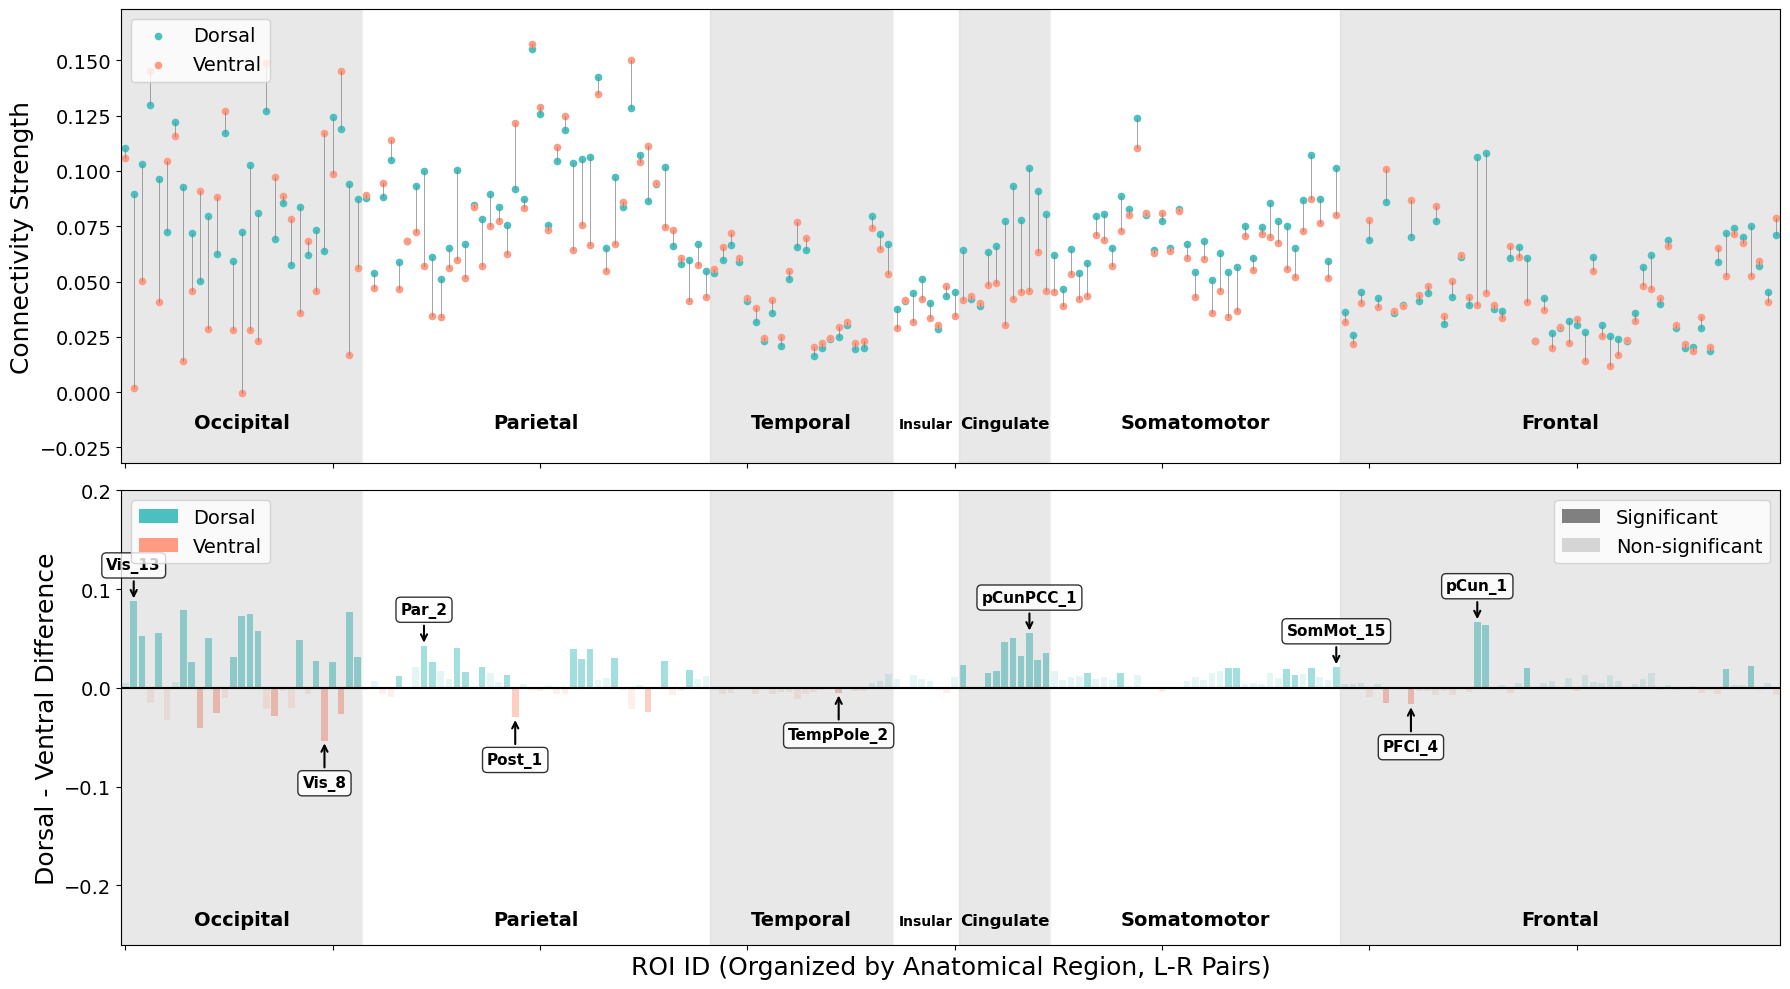

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/fc_anatomical_organization_grayscale.png

FC significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_13, Diff = 0.088
  Bottom (LO > pIPS): Vis_8, Diff = -0.053

Parietal Lobe:
  Peak (pIPS > LO): Par_2, Diff = 0.043
  Bottom (LO > pIPS): Post_1, Diff = -0.030

Temporal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): TempPole_2, Diff = -0.005

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_1, Diff = 0.055
  No significant LO-preferring ROIs in this lobe

Somatomotor Lobe:
  Peak (pIPS > LO): SomMot_15, Diff = 0.021
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): pCun_1, Diff = 0.067
  Bottom (LO > pIPS): PFCl_4, Diff = -0.017
Loaded PPI data with 200 ROIs

Creating PPI anatomical organization visualization...


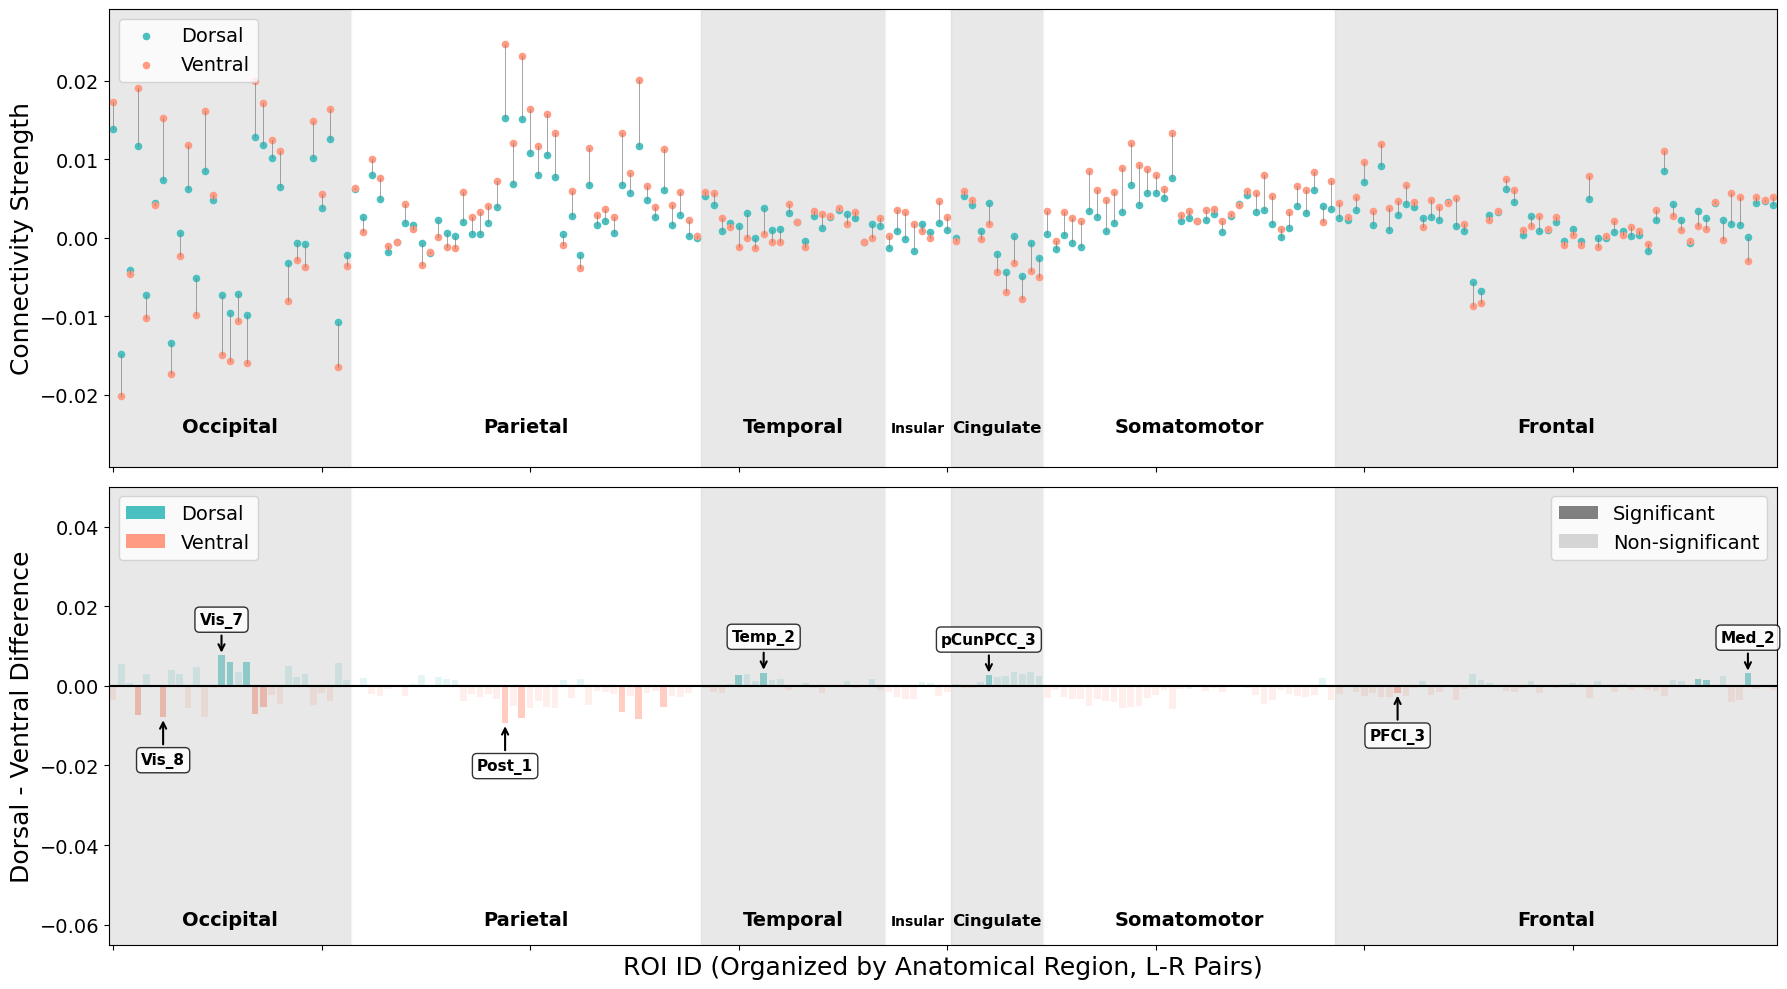

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/ppi_anatomical_organization_grayscale.png

PPI significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_7, Diff = 0.008
  Bottom (LO > pIPS): Vis_8, Diff = -0.008

Parietal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): Post_1, Diff = -0.009

Temporal Lobe:
  Peak (pIPS > LO): Temp_2, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_3, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): Med_2, Diff = 0.003
  Bottom (LO > pIPS): PFCl_3, Diff = -0.002


In [ ]:
# Standalone cell for FC and PPI visualization - alternating gray/white background

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch

# Define paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_comparison'
os.makedirs(output_dir, exist_ok=True)

# Helper functions
def map_to_anatomical_lobe(roi_name):
    """Map ROI names to anatomical lobes"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'Wang_pIPS' in roi_name:
        return 'Parietal'
    elif 'Wang_LO' in roi_name:
        return 'Temporal'
    
    if 'Vis' in roi_name:
        return 'Occipital'
    elif 'SomMot' in roi_name:
        return 'Somatomotor'
    elif 'DorsAttn' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        else:
            return 'Parietal'
    elif 'SalVentAttn' in roi_name:
        if 'Ins' in roi_name:
            return 'Insular'
        elif 'Cing' in roi_name or 'ACC' in roi_name:
            return 'Cingulate'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'Par' in roi_name:
            return 'Parietal'
        else:
            return 'Frontal'
    elif 'Limbic' in roi_name:
        if 'Temp' in roi_name:
            return 'Temporal'
        else:
            return 'Frontal'
    elif 'Cont' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        elif 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    elif 'Default' in roi_name:
        if 'Par' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'PCC' in roi_name or 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    else:
        return 'Other'

def clean_roi_name(roi_name):
    """Clean up ROI names for better labeling"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'Wang_' in roi_name:
        return roi_name.replace('Wang_', '')
    
    cleaned = roi_name.replace('7Networks_', '')
    
    parts = cleaned.split('_')
    if len(parts) > 2:
        return parts[-2] + '_' + parts[-1]
    elif len(parts) > 1:
        return parts[-1]
    else:
        return cleaned

def get_hemisphere_and_region(roi_name):
    """Determine hemisphere and base region for organizing pairs"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'LH' in roi_name:
        hemisphere = 'L'
    elif 'RH' in roi_name:
        hemisphere = 'R'
    else:
        if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
            hemisphere = 'X'
        else:
            hemisphere = 'X'
    
    cleaned = roi_name.replace('7Networks_', '')
    cleaned = cleaned.replace('LH_', '').replace('RH_', '')
    
    if 'Wang_' in cleaned:
        base_region = cleaned.replace('Wang_', '')
    else:
        base_region = re.sub(r'_\d+$', '', cleaned)
    
    return hemisphere, base_region

def load_data_for_visualization(analysis_type='fc'):
    """Load data from CSV and prepare it for visualization"""
    csv_path = f'{output_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    
    if not os.path.exists(csv_path):
        print(f"Error: {analysis_type.upper()} results file not found at {csv_path}")
        return None, None
        
    results_df = pd.read_csv(csv_path)
    print(f"Loaded {analysis_type.upper()} data with {len(results_df)} ROIs")
    
    roi_data = {
        'mean_pips': results_df['pIPS_Connectivity'].values,
        'mean_lo': results_df['LO_Connectivity'].values,
        'diff_profile': results_df['Difference'].values,
        'ci_lower': results_df['CI_Lower'].values,
        'ci_upper': results_df['CI_Upper'].values,
        'sig_combined': results_df['Combined_Significant'].values
    }
    
    return results_df, roi_data

def visualize_anatomical_organization(results_df, roi_data, analysis_type='fc'):
    """Create anatomical organization visualization with alternating gray/white background"""
    print(f"\nCreating {analysis_type.upper()} anatomical organization visualization...")
    
    mean_pips = roi_data['mean_pips']
    mean_lo = roi_data['mean_lo']
    diff_profile = roi_data['diff_profile']
    ci_lower = roi_data['ci_lower']
    ci_upper = roi_data['ci_upper']
    sig_combined = roi_data['sig_combined']
    
    results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
    results_df['Clean_Name'] = results_df['ROI_Name'].apply(clean_roi_name)
    
    hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
    results_df['Hemisphere'] = [h for h, r in hemisphere_region]
    results_df['Base_Region'] = [r for h, r in hemisphere_region]
    
    lobe_order = [
        'Occipital',
        'Parietal',
        'Temporal',
        'Insular',
        'Cingulate',
        'Somatomotor',
        'Frontal',
        'Other'
    ]
    
    lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
    results_df['Lobe_Sorted'] = lobe_cat
    
    def custom_sort(row):
        lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
        hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
        return (lobe_idx, row['Base_Region'], hemi_idx)
    
    results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
    results_df_sorted = results_df.sort_values('sort_key')
    
    sorted_indices = results_df_sorted.index.values
    
    mean_pips_sorted = results_df_sorted['pIPS_Connectivity'].values
    mean_lo_sorted = results_df_sorted['LO_Connectivity'].values
    diff_profile_sorted = results_df_sorted['Difference'].values
    sig_sorted = results_df_sorted['Combined_Significant'].values
    
    significant_roi_positions = []
    lobe_sections = []
    
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                lobe_sections.append((current_lobe, start_idx, i-1))
            current_lobe = lobe
            start_idx = i
    
    if current_lobe is not None:
        lobe_sections.append((current_lobe, start_idx, len(sorted_indices)-1))
    
    for lobe, start, end in lobe_sections:
        section_indices = sorted_indices[start:end+1]
        section_diff = diff_profile_sorted[start:end+1]
        section_sig = sig_sorted[start:end+1]
        
        sig_positions = np.where(section_sig)[0]
        if len(sig_positions) > 0:
            sig_diffs = section_diff[sig_positions]
            
            if np.max(sig_diffs) > 0:
                max_sig_idx = sig_positions[np.argmax(sig_diffs)]
                significant_roi_positions.append(start + max_sig_idx)
            
            if np.min(sig_diffs) < 0:
                min_sig_idx = sig_positions[np.argmin(sig_diffs)]
                significant_roi_positions.append(start + min_sig_idx)
    
    plt.figure(figsize=(18, 10))
    
    ax1 = plt.subplot(2, 1, 1)
    x = np.arange(len(mean_pips_sorted))
    
    y_min, y_max = min(min(mean_pips_sorted), min(mean_lo_sorted)), max(max(mean_pips_sorted), max(mean_lo_sorted))
    y_range = y_max - y_min
    
    # Alternating gray/white backgrounds
    for i, (lobe, start, end) in enumerate(lobe_sections):
        bg_color = '#d3d3d3' if i % 2 == 0 else 'white'
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.5, color=bg_color)
        label_y = y_min - 0.1 * y_range
        # Adjust fontsize for Insular and Cingulate
        if lobe == 'Insular':
            lobe_fontsize = 12
        elif lobe == 'Cingulate':
            lobe_fontsize = 12
        else:
            lobe_fontsize = 14
        plt.text((start + end) / 2, label_y, lobe, ha='center', fontsize=lobe_fontsize, fontweight='bold')
    
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [mean_pips_sorted[i], mean_lo_sorted[i]], color='gray', linestyle='-', linewidth=0.5)
    
    plt.scatter(x, mean_pips_sorted, color='#4ac0c0', s=20, label='Dorsal')
    plt.scatter(x, mean_lo_sorted, color='#ff9b83', s=20, label='Ventral')
    
    plt.ylim(y_min - 0.2 * y_range, y_max + 0.1 * y_range)
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.tick_params(axis='both', labelsize=14)
    plt.ylabel('Connectivity Strength', fontsize=18)
    plt.legend(loc='upper left', fontsize=14)
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    ax2 = plt.subplot(2, 1, 2)
    
    diff_min, diff_max = min(diff_profile_sorted), max(diff_profile_sorted)
    diff_range = diff_max - diff_min
    
    base_colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile_sorted]
    bars = plt.bar(x, diff_profile_sorted, color=base_colors)
    
    for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
        if not is_sig:
            bar.set_alpha(0.3)
    
    plt.axhline(y=0, color='black', linestyle='-')
    
    sig_legend_elements = [
        Patch(facecolor='gray', alpha=1.0, label='Significant'),
        Patch(facecolor='gray', alpha=0.3, label='Non-significant')
    ]
    sig_legend = plt.legend(handles=sig_legend_elements, loc='upper right', fontsize=14)
    
    plt.gca().add_artist(sig_legend)
    
    pref_legend_elements = [
        Patch(facecolor='#4ac0c0', label='Dorsal'),
        Patch(facecolor='#ff9b83', label='Ventral')
    ]
    plt.legend(handles=pref_legend_elements, loc='upper left', fontsize=14)
    
    # Alternating gray/white backgrounds
    for i, (lobe, start, end) in enumerate(lobe_sections):
        bg_color = '#d3d3d3' if i % 2 == 0 else 'white'
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.5, color=bg_color)
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.tick_params(axis='both', labelsize=14)
    
    for position in significant_roi_positions:
        orig_idx = sorted_indices[position]
        roi_name = results_df.loc[orig_idx, 'Clean_Name']
        diff_value = diff_profile_sorted[position]
        
        plt.annotate(f'{roi_name}',
                    xy=(position, diff_value),
                    xytext=(0, 20 if diff_value >= 0 else -25),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if diff_value >= 0 else 'top',
                    fontsize=11,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
    
    plt.ylabel('Dorsal - Ventral Difference', fontsize=18)
    plt.xlabel('ROI ID (Organized by Anatomical Region, L-R Pairs)', fontsize=18)
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    if analysis_type == 'fc':
        plt.ylim(-0.2, 0.2)
    else:
        plt.ylim(-0.05, 0.05)
    
    current_ylim = plt.ylim()
    y_range_bottom = current_ylim[1] - current_ylim[0]
    
    for i, (lobe, start, end) in enumerate(lobe_sections):
        label_y = current_ylim[0] - 0.1 * y_range_bottom
        # Adjust fontsize for Insular and Cingulate
        if lobe == 'Insular':
            lobe_fontsize = 12
        elif lobe == 'Cingulate':
            lobe_fontsize = 12
        else:
            lobe_fontsize = 14
        plt.text((start + end) / 2, label_y, lobe, ha='center', fontsize=lobe_fontsize, fontweight='bold')
    
    plt.ylim(current_ylim[0] - 0.15 * y_range_bottom, current_ylim[1])
    
    plt.tight_layout()
    
    # Save with different filename to preserve original
    fig_path = f'{output_dir}/{analysis_type}_anatomical_organization_grayscale.png'
    plt.savefig(fig_path, dpi=300)
    plt.show()
    print(f"Figure saved to {fig_path}")
    
    print(f"\n{analysis_type.upper()} significant peak and bottom ROIs by anatomical lobe:")
    for lobe, start, end in lobe_sections:
        section_indices = sorted_indices[start:end+1]
        section_df = results_df.loc[section_indices]
        
        sig_group = section_df[section_df['Combined_Significant']]
        
        if len(sig_group) > 0:
            print(f"\n{lobe} Lobe:")
            
            pips_group = sig_group[sig_group['Difference'] > 0]
            if len(pips_group) > 0:
                peak_row = pips_group.loc[pips_group['Difference'].idxmax()]
                print(f"  Peak (pIPS > LO): {peak_row['Clean_Name']}, " +
                      f"Diff = {peak_row['Difference']:.3f}")
            else:
                print("  No significant pIPS-preferring ROIs in this lobe")
            
            lo_group = sig_group[sig_group['Difference'] < 0]
            if len(lo_group) > 0:
                bottom_row = lo_group.loc[lo_group['Difference'].idxmin()]
                print(f"  Bottom (LO > pIPS): {bottom_row['Clean_Name']}, " +
                      f"Diff = {bottom_row['Difference']:.3f}")
            else:
                print("  No significant LO-preferring ROIs in this lobe")

# Run visualizations
fc_results, fc_data = load_data_for_visualization('fc')
if fc_results is not None and fc_data is not None:
    visualize_anatomical_organization(fc_results, fc_data, analysis_type='fc')

ppi_results, ppi_data = load_data_for_visualization('ppi')
if ppi_results is not None and ppi_data is not None:
    visualize_anatomical_organization(ppi_results, ppi_data, analysis_type='ppi')

Loaded FC data with 200 ROIs

Creating FC anatomical organization visualization...


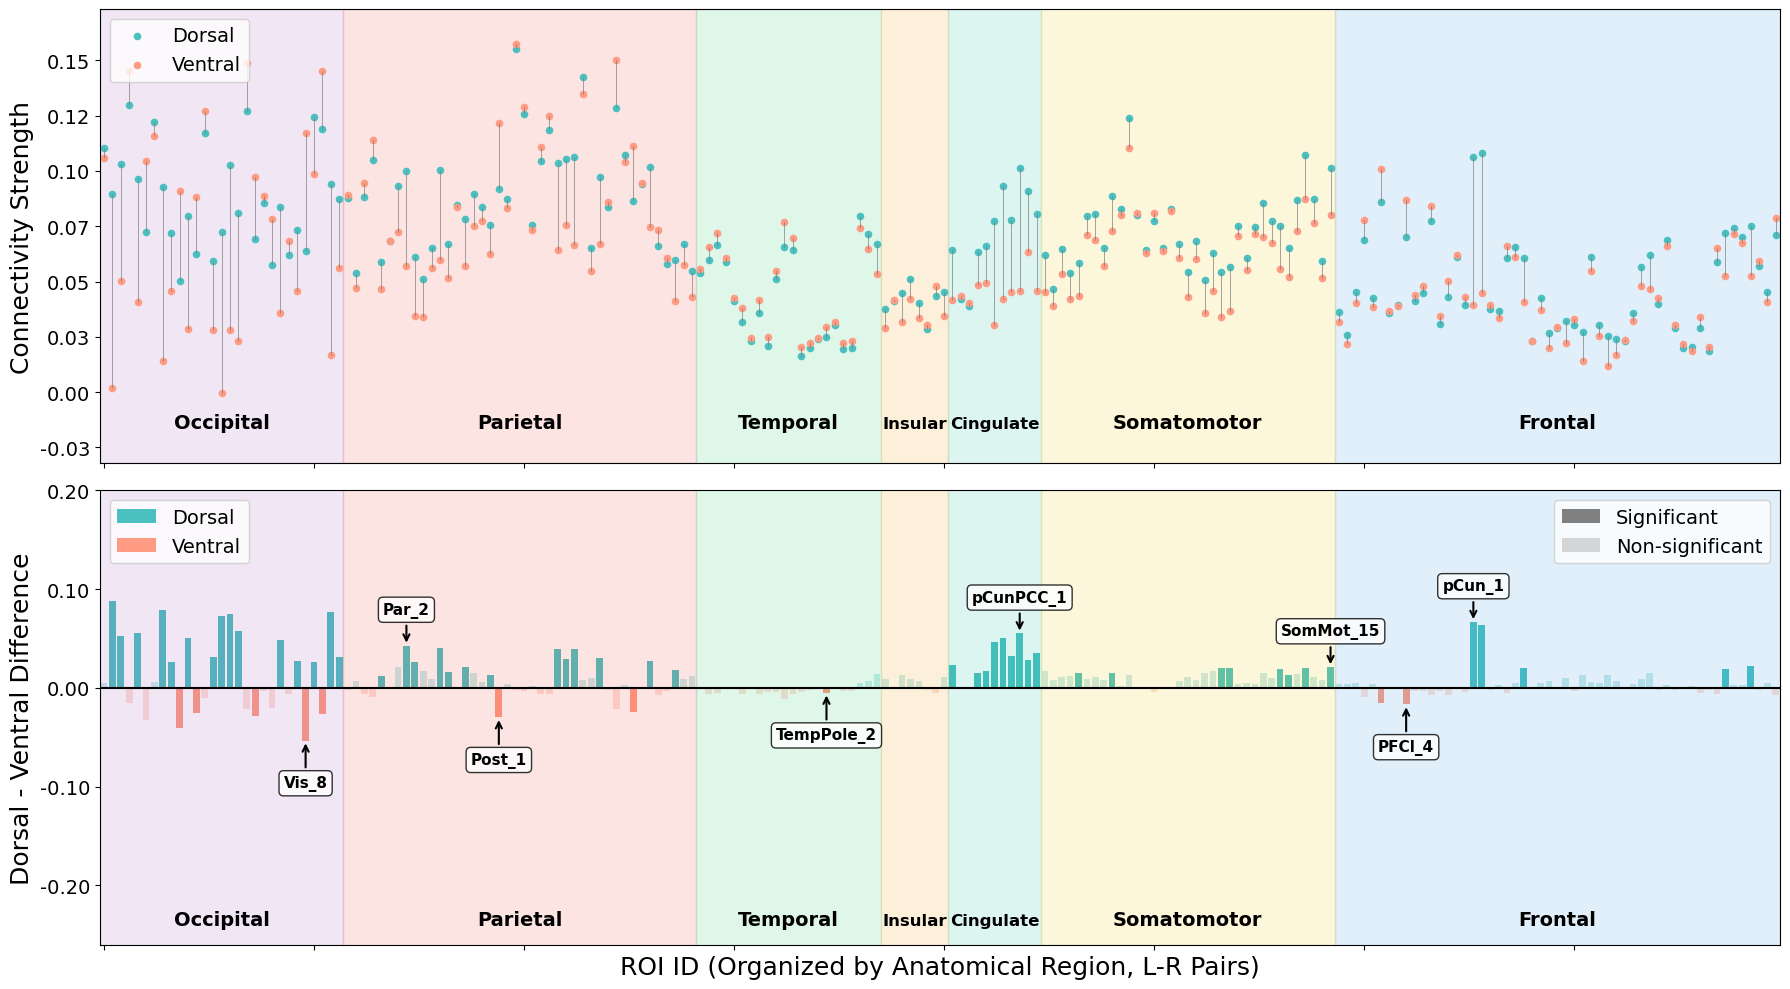

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/fc_anatomical_organization.png

FC significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_13, Diff = 0.088
  Bottom (LO > pIPS): Vis_8, Diff = -0.053

Parietal Lobe:
  Peak (pIPS > LO): Par_2, Diff = 0.043
  Bottom (LO > pIPS): Post_1, Diff = -0.030

Temporal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): TempPole_2, Diff = -0.005

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_1, Diff = 0.055
  No significant LO-preferring ROIs in this lobe

Somatomotor Lobe:
  Peak (pIPS > LO): SomMot_15, Diff = 0.021
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): pCun_1, Diff = 0.067
  Bottom (LO > pIPS): PFCl_4, Diff = -0.017
Loaded PPI data with 200 ROIs

Creating PPI anatomical organization visualization...


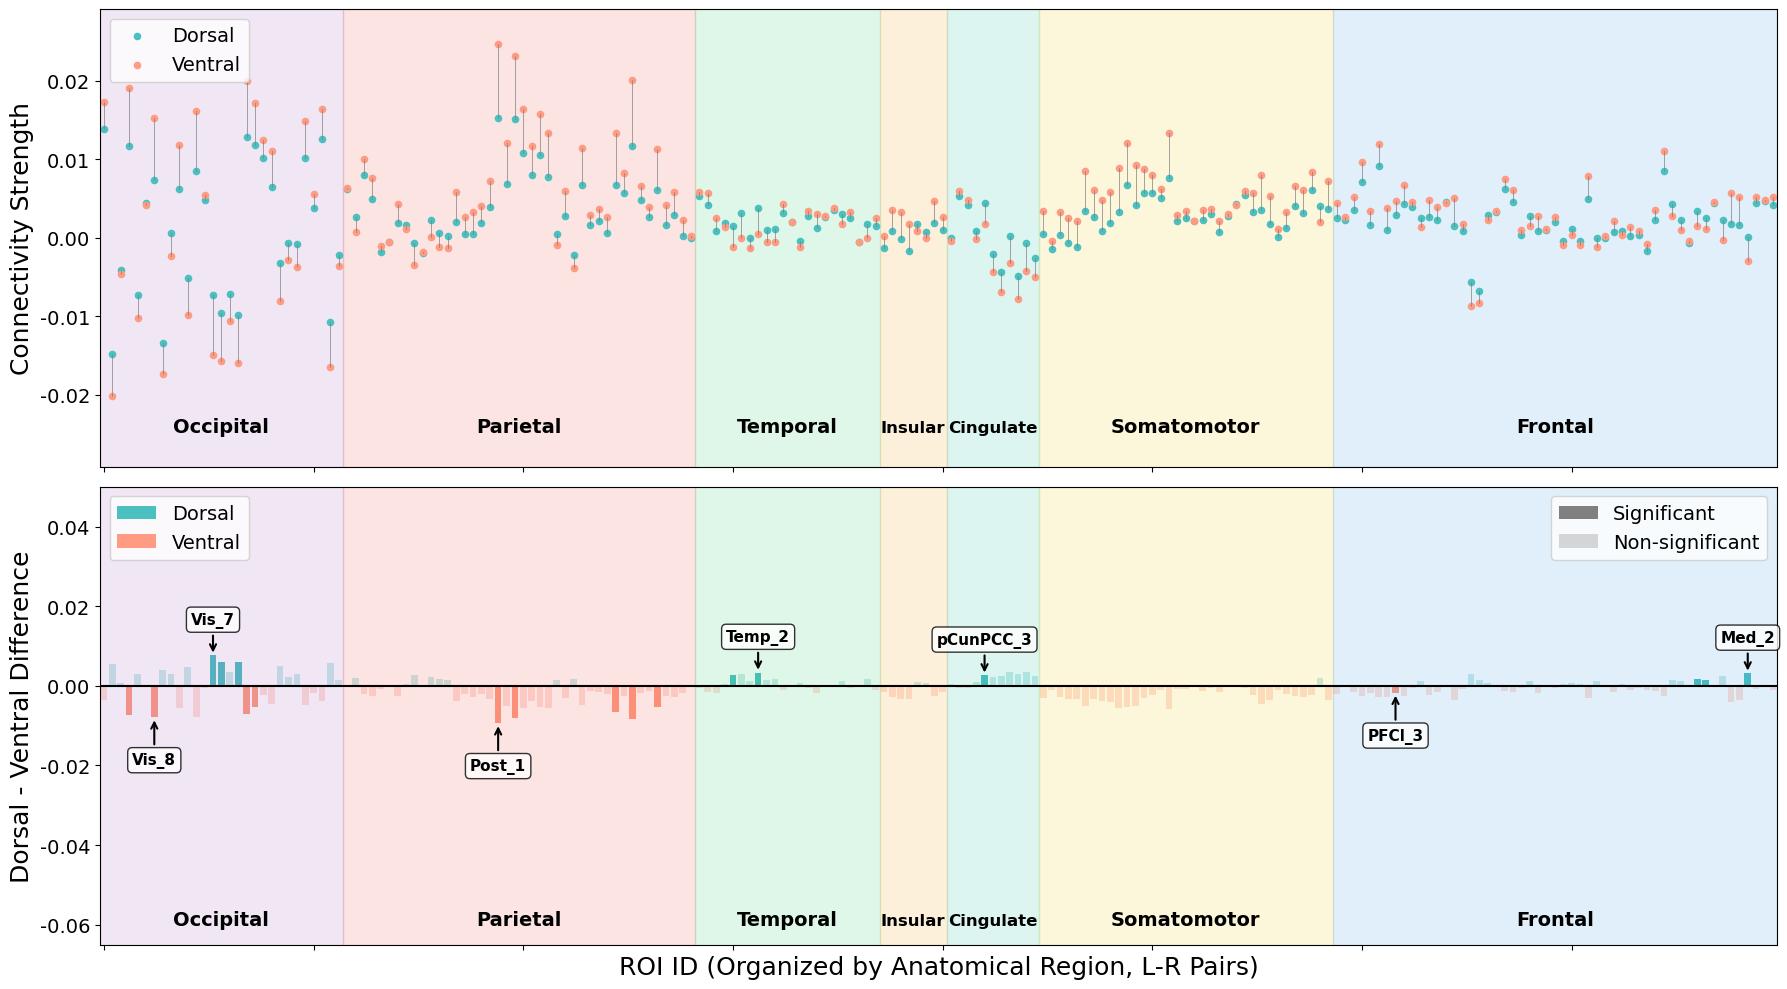

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/ppi_anatomical_organization.png

PPI significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_7, Diff = 0.008
  Bottom (LO > pIPS): Vis_8, Diff = -0.008

Parietal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): Post_1, Diff = -0.009

Temporal Lobe:
  Peak (pIPS > LO): Temp_2, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_3, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): Med_2, Diff = 0.003
  Bottom (LO > pIPS): PFCl_3, Diff = -0.002


In [1]:
# Standalone cell for FC and PPI visualization

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter

# Define paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_comparison'
os.makedirs(output_dir, exist_ok=True)

# Helper functions
def map_to_anatomical_lobe(roi_name):
    """Map ROI names to anatomical lobes"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'Wang_pIPS' in roi_name:
        return 'Parietal'
    elif 'Wang_LO' in roi_name:
        return 'Temporal'
    
    if 'Vis' in roi_name:
        return 'Occipital'
    elif 'SomMot' in roi_name:
        return 'Somatomotor'
    elif 'DorsAttn' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        else:
            return 'Parietal'
    elif 'SalVentAttn' in roi_name:
        if 'Ins' in roi_name:
            return 'Insular'
        elif 'Cing' in roi_name or 'ACC' in roi_name:
            return 'Cingulate'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'Par' in roi_name:
            return 'Parietal'
        else:
            return 'Frontal'
    elif 'Limbic' in roi_name:
        if 'Temp' in roi_name:
            return 'Temporal'
        else:
            return 'Frontal'
    elif 'Cont' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        elif 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    elif 'Default' in roi_name:
        if 'Par' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'PCC' in roi_name or 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    else:
        return 'Other'

def clean_roi_name(roi_name):
    """Clean up ROI names for better labeling"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'Wang_' in roi_name:
        return roi_name.replace('Wang_', '')
    
    cleaned = roi_name.replace('7Networks_', '')
    
    parts = cleaned.split('_')
    if len(parts) > 2:
        return parts[-2] + '_' + parts[-1]
    elif len(parts) > 1:
        return parts[-1]
    else:
        return cleaned

def get_hemisphere_and_region(roi_name):
    """Determine hemisphere and base region for organizing pairs"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'LH' in roi_name:
        hemisphere = 'L'
    elif 'RH' in roi_name:
        hemisphere = 'R'
    else:
        if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
            hemisphere = 'X'
        else:
            hemisphere = 'X'
    
    cleaned = roi_name.replace('7Networks_', '')
    cleaned = cleaned.replace('LH_', '').replace('RH_', '')
    
    if 'Wang_' in cleaned:
        base_region = cleaned.replace('Wang_', '')
    else:
        base_region = re.sub(r'_\d+$', '', cleaned)
    
    return hemisphere, base_region

def load_data_for_visualization(analysis_type='fc'):
    """Load data from CSV and prepare it for visualization"""
    csv_path = f'{output_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    
    if not os.path.exists(csv_path):
        print(f"Error: {analysis_type.upper()} results file not found at {csv_path}")
        return None, None
        
    results_df = pd.read_csv(csv_path)
    print(f"Loaded {analysis_type.upper()} data with {len(results_df)} ROIs")
    
    roi_data = {
        'mean_pips': results_df['pIPS_Connectivity'].values,
        'mean_lo': results_df['LO_Connectivity'].values,
        'diff_profile': results_df['Difference'].values,
        'ci_lower': results_df['CI_Lower'].values,
        'ci_upper': results_df['CI_Upper'].values,
        'sig_combined': results_df['Combined_Significant'].values
    }
    
    return results_df, roi_data

def visualize_anatomical_organization(results_df, roi_data, analysis_type='fc'):
    """Create anatomical organization visualization"""
    print(f"\nCreating {analysis_type.upper()} anatomical organization visualization...")
    
    mean_pips = roi_data['mean_pips']
    mean_lo = roi_data['mean_lo']
    diff_profile = roi_data['diff_profile']
    ci_lower = roi_data['ci_lower']
    ci_upper = roi_data['ci_upper']
    sig_combined = roi_data['sig_combined']
    
    results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
    results_df['Clean_Name'] = results_df['ROI_Name'].apply(clean_roi_name)
    
    hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
    results_df['Hemisphere'] = [h for h, r in hemisphere_region]
    results_df['Base_Region'] = [r for h, r in hemisphere_region]
    
    lobe_order = [
        'Occipital',
        'Parietal',
        'Temporal',
        'Insular',
        'Cingulate',
        'Somatomotor',
        'Frontal',
        'Other'
    ]
    
    lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
    results_df['Lobe_Sorted'] = lobe_cat
    
    lobe_colors = {
        'Frontal': '#3498db',
        'Somatomotor': '#f1c40f',
        'Parietal': '#e74c3c',
        'Temporal': '#2ecc71',
        'Occipital': '#9b59b6',
        'Insular': '#f39c12',
        'Cingulate': '#1abc9c',
        'Other': '#7f8c8d'
    }
    
    def custom_sort(row):
        lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
        hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
        return (lobe_idx, row['Base_Region'], hemi_idx)
    
    results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
    results_df_sorted = results_df.sort_values('sort_key')
    
    sorted_indices = results_df_sorted.index.values
    
    mean_pips_sorted = results_df_sorted['pIPS_Connectivity'].values
    mean_lo_sorted = results_df_sorted['LO_Connectivity'].values
    diff_profile_sorted = results_df_sorted['Difference'].values
    sig_sorted = results_df_sorted['Combined_Significant'].values
    
    significant_roi_positions = []
    lobe_sections = []
    
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                lobe_sections.append((current_lobe, start_idx, i-1))
            current_lobe = lobe
            start_idx = i
    
    if current_lobe is not None:
        lobe_sections.append((current_lobe, start_idx, len(sorted_indices)-1))
    
    for lobe, start, end in lobe_sections:
        section_indices = sorted_indices[start:end+1]
        section_diff = diff_profile_sorted[start:end+1]
        section_sig = sig_sorted[start:end+1]
        
        sig_positions = np.where(section_sig)[0]
        if len(sig_positions) > 0:
            sig_diffs = section_diff[sig_positions]
            
            if np.max(sig_diffs) > 0:
                max_sig_idx = sig_positions[np.argmax(sig_diffs)]
                significant_roi_positions.append(start + max_sig_idx)
            
            if np.min(sig_diffs) < 0:
                min_sig_idx = sig_positions[np.argmin(sig_diffs)]
                significant_roi_positions.append(start + min_sig_idx)
    
    plt.figure(figsize=(18, 10))
    
    ax1 = plt.subplot(2, 1, 1)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    x = np.arange(len(mean_pips_sorted))
    
    y_min, y_max = min(min(mean_pips_sorted), min(mean_lo_sorted)), max(max(mean_pips_sorted), max(mean_lo_sorted))
    y_range = y_max - y_min
    
    for lobe, start, end in lobe_sections:
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.15, color=lobe_colors[lobe])
        label_y = y_min - 0.1 * y_range
        if lobe == 'Insular':
            lobe_fontsize = 12
        elif lobe == 'Cingulate':
            lobe_fontsize = 12
        else:
            lobe_fontsize = 14
        plt.text((start + end) / 2, label_y, lobe, ha='center', fontsize=lobe_fontsize, fontweight='bold')
    
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [mean_pips_sorted[i], mean_lo_sorted[i]], color='gray', linestyle='-', linewidth=0.5)
    
    plt.scatter(x, mean_pips_sorted, color='#4ac0c0', s=20, label='Dorsal')
    plt.scatter(x, mean_lo_sorted, color='#ff9b83', s=20, label='Ventral')
    
    plt.ylim(y_min - 0.2 * y_range, y_max + 0.1 * y_range)
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.tick_params(axis='both', labelsize=14)
    plt.ylabel('Connectivity Strength', fontsize=18)
    plt.legend(loc='upper left', fontsize=14)
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    ax2 = plt.subplot(2, 1, 2)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    diff_min, diff_max = min(diff_profile_sorted), max(diff_profile_sorted)
    diff_range = diff_max - diff_min
    
    base_colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile_sorted]
    bars = plt.bar(x, diff_profile_sorted, color=base_colors)
    
    for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
        if not is_sig:
            bar.set_alpha(0.3)
    
    plt.axhline(y=0, color='black', linestyle='-')
    
    sig_legend_elements = [
        Patch(facecolor='gray', alpha=1.0, label='Significant'),
        Patch(facecolor='gray', alpha=0.3, label='Non-significant')
    ]
    sig_legend = plt.legend(handles=sig_legend_elements, loc='upper right', fontsize=14)
    
    plt.gca().add_artist(sig_legend)
    
    pref_legend_elements = [
        Patch(facecolor='#4ac0c0', label='Dorsal'),
        Patch(facecolor='#ff9b83', label='Ventral')
    ]
    plt.legend(handles=pref_legend_elements, loc='upper left', fontsize=14)
    
    for lobe, start, end in lobe_sections:
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.15, color=lobe_colors[lobe])
    
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    plt.tick_params(axis='both', labelsize=14)
    
    for position in significant_roi_positions:
        orig_idx = sorted_indices[position]
        roi_name = results_df.loc[orig_idx, 'Clean_Name']
        diff_value = diff_profile_sorted[position]
        
        # Skip specific labels
        if 'Vis_13' in roi_name:
            continue
        
        plt.annotate(f'{roi_name}',
                    xy=(position, diff_value),
                    xytext=(0, 20 if diff_value >= 0 else -25),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if diff_value >= 0 else 'top',
                    fontsize=11,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
    
    plt.ylabel('Dorsal - Ventral Difference', fontsize=18)
    plt.xlabel('ROI ID (Organized by Anatomical Region, L-R Pairs)', fontsize=18)
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    if analysis_type == 'fc':
        plt.ylim(-0.2, 0.2)
    else:
        plt.ylim(-0.05, 0.05)
    
    current_ylim = plt.ylim()
    y_range_bottom = current_ylim[1] - current_ylim[0]
    
    for lobe, start, end in lobe_sections:
        label_y = current_ylim[0] - 0.1 * y_range_bottom
        if lobe == 'Insular':
            lobe_fontsize = 12
        elif lobe == 'Cingulate':
            lobe_fontsize = 12
        else:
            lobe_fontsize = 14
        plt.text((start + end) / 2, label_y, lobe, ha='center', fontsize=lobe_fontsize, fontweight='bold')
    
    plt.ylim(current_ylim[0] - 0.15 * y_range_bottom, current_ylim[1])
    
    plt.tight_layout()
    
    fig_path = f'{output_dir}/{analysis_type}_anatomical_organization.png'
    plt.savefig(fig_path, dpi=300)
    plt.show()
    print(f"Figure saved to {fig_path}")
    
    print(f"\n{analysis_type.upper()} significant peak and bottom ROIs by anatomical lobe:")
    for lobe, start, end in lobe_sections:
        section_indices = sorted_indices[start:end+1]
        section_df = results_df.loc[section_indices]
        
        sig_group = section_df[section_df['Combined_Significant']]
        
        if len(sig_group) > 0:
            print(f"\n{lobe} Lobe:")
            
            pips_group = sig_group[sig_group['Difference'] > 0]
            if len(pips_group) > 0:
                peak_row = pips_group.loc[pips_group['Difference'].idxmax()]
                print(f"  Peak (pIPS > LO): {peak_row['Clean_Name']}, " +
                      f"Diff = {peak_row['Difference']:.3f}")
            else:
                print("  No significant pIPS-preferring ROIs in this lobe")
            
            lo_group = sig_group[sig_group['Difference'] < 0]
            if len(lo_group) > 0:
                bottom_row = lo_group.loc[lo_group['Difference'].idxmin()]
                print(f"  Bottom (LO > pIPS): {bottom_row['Clean_Name']}, " +
                      f"Diff = {bottom_row['Difference']:.3f}")
            else:
                print("  No significant LO-preferring ROIs in this lobe")

# Run visualizations
fc_results, fc_data = load_data_for_visualization('fc')
if fc_results is not None and fc_data is not None:
    visualize_anatomical_organization(fc_results, fc_data, analysis_type='fc')

ppi_results, ppi_data = load_data_for_visualization('ppi')
if ppi_results is not None and ppi_data is not None:
    visualize_anatomical_organization(ppi_results, ppi_data, analysis_type='ppi')